# 1.0 Imports

### 1.1 Libs

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import sweetviz as sv
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')
from plotly import express as px
from sklearn import cluster as c
from sklearn import metrics as mt
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import manifold as mn
from sklearn import ensemble as en
from sklearn import mixture as mx
from sklearn import neighbors as ne
from matplotlib import pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

### 1.2 Funções

In [2]:
def calculate_wss(X, labels):
    X = np.array(X)
    wss = 0
    for cluster in np.unique(labels):
        points = X[labels == cluster]
        centroid = points.mean(axis=0)
        wss += np.sum((points - centroid) ** 2)
    return float(wss)

### 1.3 Loading data

In [2]:
df_raw = pd.read_csv('../datasets/ecommerce.csv', encoding='unicode_escape', low_memory=False)

In [4]:
df_raw

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

       InvoiceDate  UnitPrice  CustomerID         Country  Unnamed: 8  
0        29-Nov-16       2.55     17850.0  United Kingdom         NaN  
1        29-Nov-16       3.39     17850.0  United Kingdom         NaN  
2        29-Nov-16       2.75     17850.0  United Kingdom         NaN  
3        29-Nov-16       3.39     17850.0  United Kingdom         NaN  
4        29-Nov-16       3.39     17850.0  United Kingdom         NaN  
...            ...        ...         ...             ...         ...  
541904    7-Dec-17       0.85     12680.0          France         NaN  
541905    7-Dec-17       2.10     12680.0          France         NaN  
541906    7-Dec-17       4.15     12680.0          France         NaN  
541907    7-Dec-17       4.15     12680.0          France         NaN  
541908    7-Dec-17       4.95     12680.0          France         NaN  

[541909 rows x 9 columns]

# 2.0 Descrição dos dados

In [3]:
df1 = df_raw.copy()

### 2.1 Renomear colunas

In [4]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id',
           'country', 'unnamed']

df1.columns = cols_new

### 2.2 Change types

In [5]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

### 2.3 Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
unnamed         541909
dtype: int64

### 2.4 Linhas duplicadas

In [6]:
# eliminando linhas duplicadas
df1 = df1.drop_duplicates()

In [7]:
# eliminando coluna "unnamed"
df1.drop('unnamed', axis=1, inplace=True)

In [8]:
# 'resetando' os indices do dataframe
df1 = df1.reset_index(drop=True)

### 2.5 Fillout NA

In [9]:
# o invoice_no é o numero da transação. para customer_id NaN, o invoice_no é o mesmo (para um conjunto)
# poderia associar um customer_id para as linhas que possuem o mesmo invoice_no

# Identificar os invoice_no únicos com NaN em customer_id
invoice_nan = df1[df1['customer_id'].isna()]['invoice_no'].unique()

# Criar valores únicos para cada grupo de invoice_no
invoice_value = {invoice: 20000 + i for i, invoice in enumerate(invoice_nan)}

# Substituir os NaN em customer_id 
df1['customer_id'] = df1.apply(lambda x: invoice_value[x['invoice_no']] if pd.isna(x['customer_id']) else x['customer_id'], axis=1)

In [10]:
# de maneira similar ao que foi feito para o invoice_no, agora para o description

# Criar um dicionário com a descrição para cada stock_code, sem incluir os NaN
stock = df1.dropna(subset=['description']).groupby('stock_code')['description'].first().to_dict()

# Substituir os NaN em description
df1['description'] = df1.apply(
    lambda x: stock.get(x['stock_code'], "nao-disponivel")
    if pd.isna(x['description']) else x['description'], axis=1)

In [14]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

In [15]:
df1[df1['description'] == 'nao-disponivel'].count()

invoice_no      112
stock_code      112
description     112
quantity        112
invoice_date    112
unit_price      112
customer_id     112
country         112
dtype: int64

### 2.6 Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude =['int64', 'float64', 'datetime64[ns]'])

### 2.6.1 Numerical Attributes

In [17]:
stat_desc = df1.describe().T
stat_desc

count                           mean                  min  \
quantity      536640.0                       9.620043             -80995.0   
invoice_date    536640  2017-07-01 19:22:15.670840832  2016-11-29 00:00:00   
unit_price    536640.0                       4.632661            -11062.06   
customer_id   536640.0                   16948.911963              12346.0   

                              25%                  50%                  75%  \
quantity                      1.0                  3.0                 10.0   
invoice_date  2017-03-26 00:00:00  2017-07-17 00:00:00  2017-10-16 00:00:00   
unit_price                   1.25                 2.08                 4.13   
customer_id               14367.0              16255.0              20014.0   

                              max          std  
quantity                  80995.0    219.13036  
invoice_date  2017-12-07 00:00:00          NaN  
unit_price                38970.0    97.233208  
customer_id               23709.0  3291.353325

### 2.6.2 Categorical Attributes

##### **invoice number**

In [18]:
# alguns invoice_no (que deveriam ser inteiros) apresentam letras

In [19]:
# problema: temos invoice com letras e números
# identificação:
df_letter_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]
print('Total number of invoices: {}'.format(len(df_letter_invoice)))
print('Total number of negative quantity: {}'.format(len(df_letter_invoice[df_letter_invoice['quantity'] < 0])))

Total number of invoices: 9254
Total number of negative quantity: 9251


##### **stock code**

In [20]:
# checando stock_code que apresentam apenas caracteres:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z\s]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE', 'm',
       'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [21]:
# remover stock_code(com letras)

##### **description**

In [22]:
df1['description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., 'lost',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [23]:
# remover coluna description

##### **country**

In [24]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

# 3.0 Filtragem de variáveis

In [11]:
df2 = df1.copy()

In [12]:
# --- Numerical attributes ---
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# --- Categorical attributes ---
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK', 'C2'])]

df2 = df2.drop(columns='description', axis=1)

df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# eliminando as linhas referentes a valores 'estranhos' de qtde_returns:
df2 = df2[~((df2['invoice_no'] == '581483') | (df2['invoice_no'] == 'C581484'))]  # referente a customer_id=16446
df2 = df2[~((df2['invoice_no'] == '541431') | (df2['invoice_no'] == 'C541433'))]  # referente a customer_id=12346
df2 = df2[~((df2['invoice_no'] == '540815') | (df2['invoice_no'] == 'C550456'))]  # referente a customer_id=15749

df2_return = df2.loc[df1['quantity'] < 0, :]  # produtos retornados
df2_purchase = df2.loc[df1['quantity'] >= 0, :]  # produtos comprados

# 4.0 Feature Engineering

In [13]:
df3 = df2.copy()

### 4.1 Feature Creation

In [14]:
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

In [29]:
# A segmentação dos clientes será 'baseada' no método RFM - uma ferramenta de segmentação de clientes que analisa
# o comportamento de compra baseado em três critérios: Recência, Frequência e Valor Monetário.
# Recência (R): o tempo decorrido desde a última compra do cliente. 
# Frequência (F): medida do número de compras realizadas por um cliente em um período específico.  
# Valor Monetário (M): o total gasto por um cliente. 

# Assim, como a tabela de dados não contém essas variáveis, vamos calculá-las:

##### **4.1.1 Gross Revenue**

In [15]:
# monetary (faturamento) = quantity*price --> soma produtos comprados - soma produtos retornados 
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
dtype: int64

##### **4.1.2 Recency - Days from last purchase**

In [16]:
# recency (last day purchase)
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days # em relação à mais recente data do dataframe
df_recency = df_recency[['customer_id', 'recency_days']].copy() # pegando as colunas de interesse
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue     0
recency_days     67
dtype: int64

In [32]:
# a diferença 67 se refere à diferença entre (df_ref - df_purchase(agrupado por customer_id)), 

##### **4.1.3 Frequency purchase**

In [17]:
df_aux = (df2[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby('customer_id')
                                                            .agg(max_ = ('invoice_date', max),
                                                                 min_ = ('invoice_date', min),
                                                                 days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                 buy_ = ('invoice_no', 'count')).reset_index())

df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue     0
recency_days     67
frequency         0
dtype: int64

##### **4.1.4 Quantidade de produtos retornados**

In [18]:
df_prod_return = df2_return[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_prod_returns'})
df_prod_return['qtde_prod_returns'] = df_prod_return['qtde_prod_returns'].abs()

df_ref = pd.merge(df_ref, df_prod_return, how='left', on='customer_id')
df_ref.loc[df_ref['qtde_prod_returns'].isna(), 'qtde_prod_returns'] = 0  # preenche os valores nan com zero
df_ref.isna().sum()

customer_id           0
gross_revenue         0
recency_days         67
frequency             0
qtde_prod_returns     0
dtype: int64

In [35]:
# O número de devoluções do ciclo 4 foi alterado para quantidade de produtos devolvidos (retornados)

##### **4.1.5 Número de pedidos (invoices)** 

In [19]:
df_invoices = (df2_purchase.loc[:,['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id')
                                                                .count().reset_index()
                                                                .rename(columns={'invoice_no':'qtde_invoices'}))
df_ref = pd.merge(df_ref, df_invoices, on='customer_id', how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue         0
recency_days         67
frequency             0
qtde_prod_returns     0
qtde_invoices        67
dtype: int64

##### **4.1.6 Quantidade de produtos comprados**

In [20]:
df_products = (df2_purchase.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
                                                               .rename(columns={'quantity':'qtde_products'}))
df_ref = pd.merge(df_ref, df_products, on='customer_id', how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue         0
recency_days         67
frequency             0
qtde_prod_returns     0
qtde_invoices        67
qtde_products        67
dtype: int64

##### **4.1.7 Número de devoluções feitas**

In [21]:
# número de devoluções feitas independente que quantos produtos foram devolvidos
df_return = (df2_return.loc[:,['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id')
                                                            .count().reset_index()
                                                            .rename(columns={'invoice_no':'qtde_returns'}))
df_ref = pd.merge(df_ref, df_return, how='left', on='customer_id')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0  # preenche os valores nan com zero
df_ref.isna().sum()

customer_id           0
gross_revenue         0
recency_days         67
frequency             0
qtde_prod_returns     0
qtde_invoices        67
qtde_products        67
qtde_returns          0
dtype: int64

##### **4.1.8 Quantidade total de produtos comprados**

In [39]:
# quantidade total = produtos comprados - produtos devolvidos
# devido à grande semelhança entre esta variável e qtde_products, nesse ciclo, não vamos
# trabalhar com a qtde_prod_total

# 5.0 EDA - Exploratory Data Analysis

In [22]:
df4 = df_ref.copy()
df4 = df_ref.dropna()
df4.isna().sum()

customer_id          0
gross_revenue        0
recency_days         0
frequency            0
qtde_prod_returns    0
qtde_invoices        0
qtde_products        0
qtde_returns         0
dtype: int64

In [24]:
df4.shape

(5694, 8)

### 5.1 **Análise Univariada**

In [42]:
#report = sv.analyze(df4)
#report.show_html("report_v3.html")

In [43]:
# o arquivo report_v3.html apresenta análises estatísticas das variáveis presentes no dataframe e criadas na seção 4.

In [44]:
# a análise foi feita no ciclo anterior.

### 5.2 **Análise Bivariada**

In [23]:
cols = ['customer_id']
df42 = df4.drop(cols, axis=1)

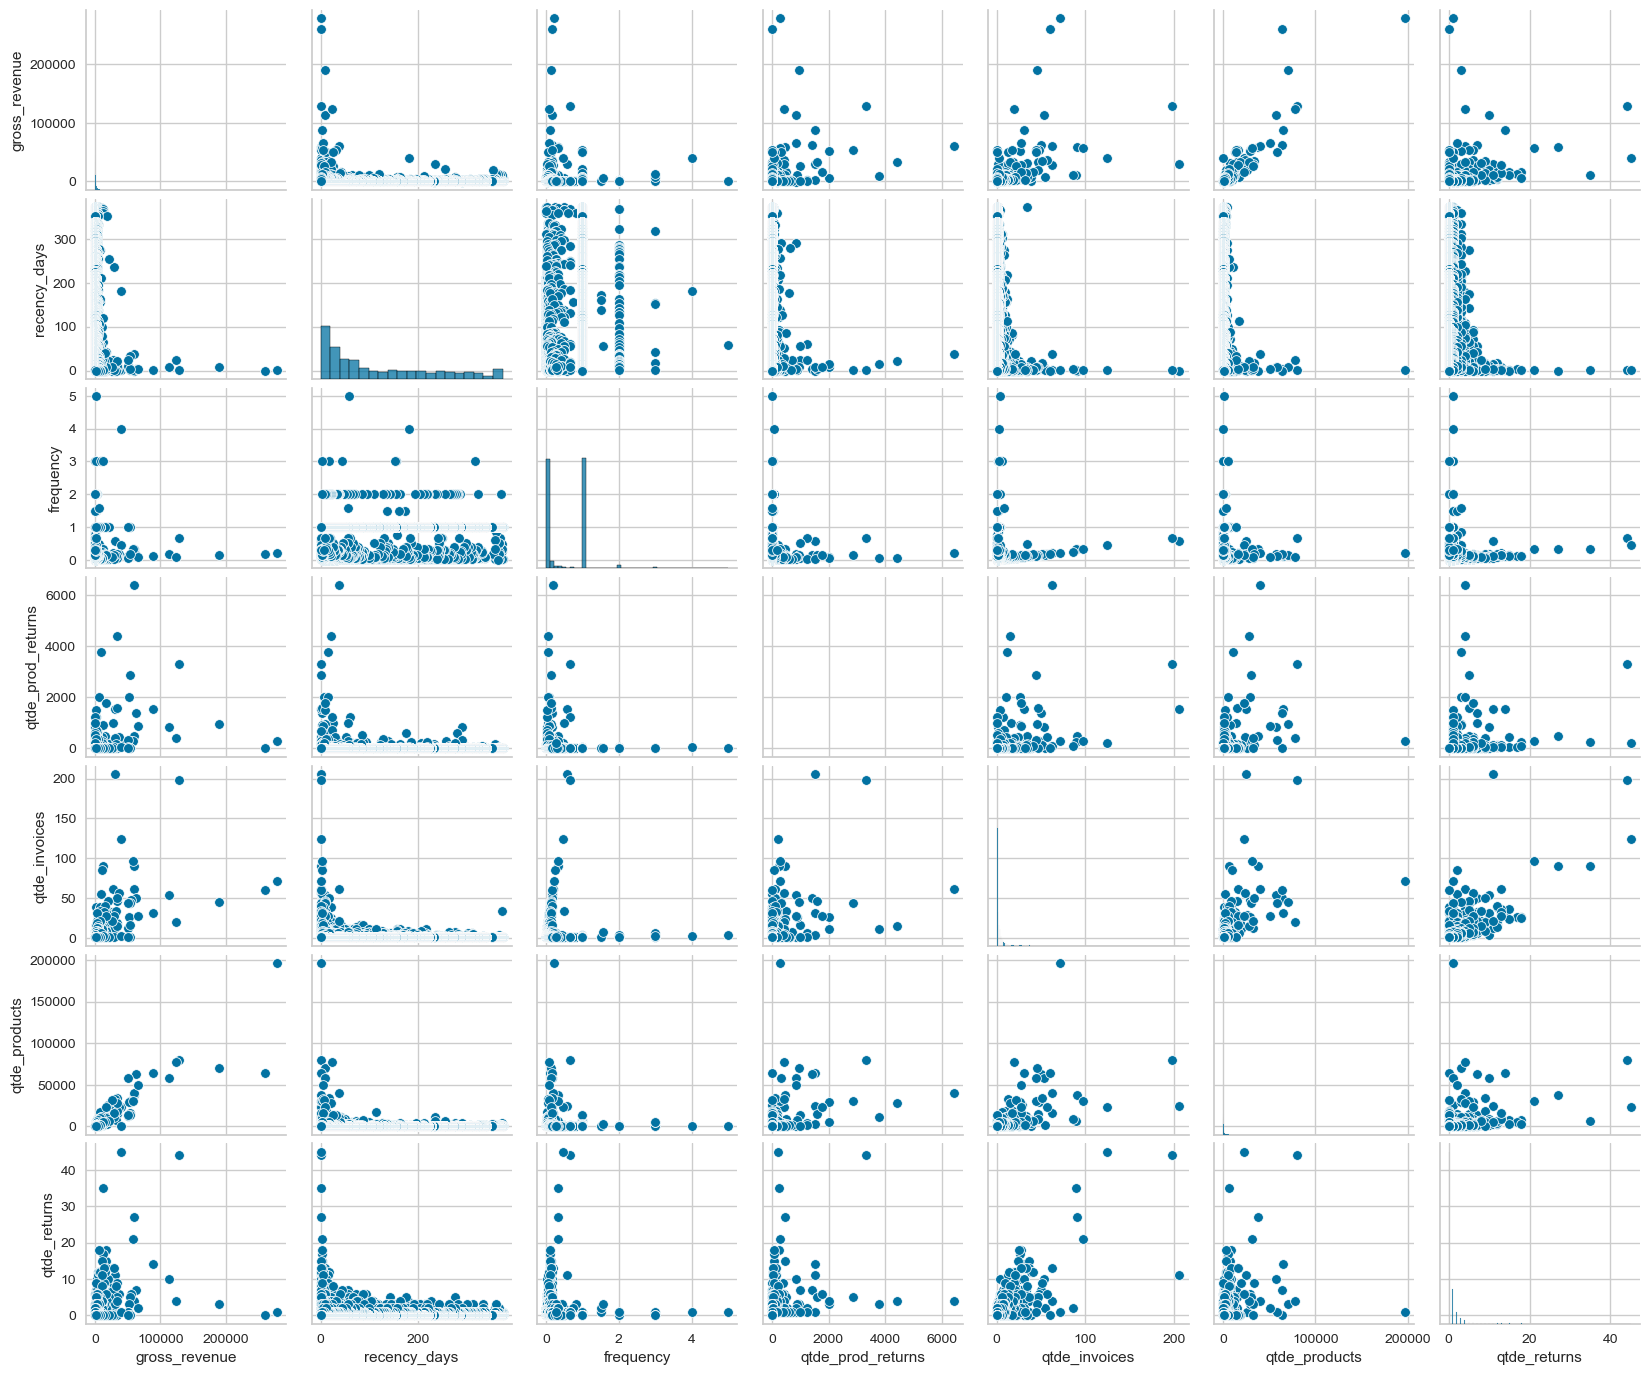

In [46]:
sns.pairplot(df42, height=2.0, aspect=1.2)

### 5.3 **Estudo do Espaço**

In [24]:
df43 = df4.drop(columns=['customer_id'], axis=1).copy()

In [48]:
# antes de aplicar o pca, é necessário fazer a padronização dos dados:

In [25]:
mm = pp.MinMaxScaler()

df43['gross_revenue']     = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days']      = mm.fit_transform(df43[['recency_days']])
df43['frequency']         = mm.fit_transform(df43[['frequency']])
df43['qtde_prod_returns'] = mm.fit_transform(df43[['qtde_prod_returns']])
df43['qtde_invoices']     = mm.fit_transform(df43[['qtde_invoices']])
df43['qtde_products']     = mm.fit_transform(df43[['qtde_products']])
df43['qtde_returns']      = mm.fit_transform(df43[['qtde_returns']])

X = df43.copy()

#### 5.3.1 **PCA (Principal Component Analysis)**

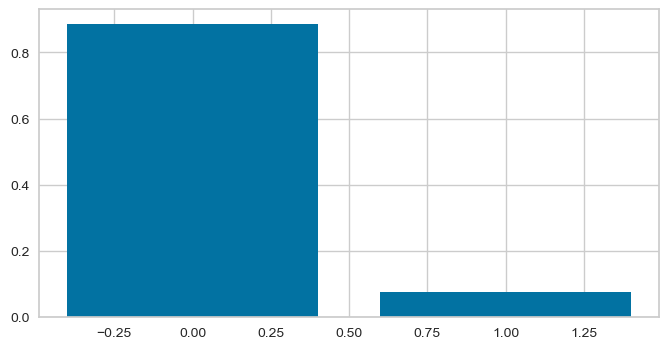

In [26]:
# pca = dd.PCA(n_components=X.shape[1])  # reduzindo para X.shape dimensões
pca = dd.PCA(n_components=2)  # reduzindo para 2 dimensões

principal_components = pca.fit_transform(X)

features = range(pca.n_components_)
plt.figure(figsize=(8, 4))
plt.bar(features, pca.explained_variance_ratio_);

In [51]:
# acima, vemos como cada componente do PC (PC1, PC2, PC3, PC4, ...) explicam a variância dos dados.

In [28]:
# verificando variância explicada:
print("Variância explicada por componente:", pca.explained_variance_ratio_)
print("Variância total explicada:", sum(pca.explained_variance_ratio_))

Variância explicada por componente: [0.8858079  0.07573266]
Variância total explicada: 0.9615405585350054


In [53]:
# contribuição de cada feature (0,1,2,3,...) para cada componente (PC1, PC2, PC3, PC4,...)

In [27]:
df_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

loadings = pd.DataFrame(
    pca.components_.T,  # para alinhar com as features
    columns=['PC1', 'PC2'],
    index=X.columns  # nomes das features originais
)

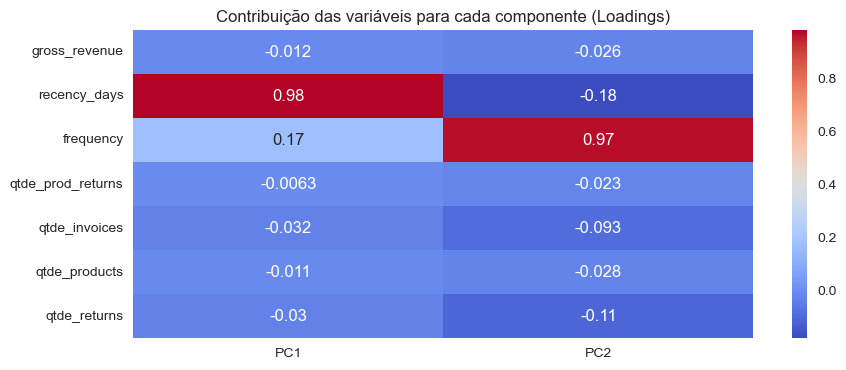

In [36]:
plt.figure(figsize=(10, 4))
sns.heatmap(loadings, annot=True, cmap='coolwarm')
plt.title('Contribuição das variáveis para cada componente (Loadings)')
plt.show()

In [56]:
# relação das features originais (baseadas na soma das variâncias) com as componentes somadas de maior 
# variância (PC1 e PC2)

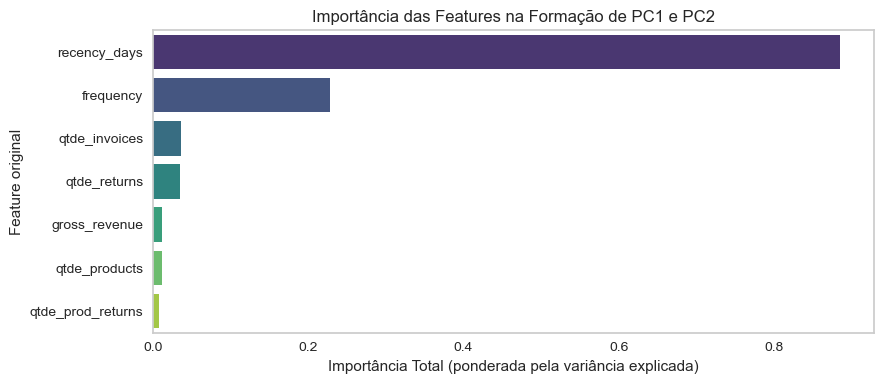

In [57]:
# selecionar os dois primeiros PCs (PC1 e PC2)
explained_var = pca.explained_variance_ratio_[:2]              # variância explicada por PC1 e PC2
abs_loadings = loadings.iloc[:, :2].abs()                      # loadings absolutos dos dois PCs

# soma dos loadings ponderados pela variância explicada
feature_importance = abs_loadings.mul(explained_var, axis=1).sum(axis=1)
feature_importance = feature_importance.sort_values(ascending=False) # ordenada em forma decrescente

loadings.index = X.columns # relacionando as features 0,1,2... com seus nomes originais

plt.figure(figsize=(9, 4))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")
plt.xlabel('Importância Total (ponderada pela variância explicada)')
plt.ylabel('Feature original')
plt.title('Importância das Features na Formação de PC1 e PC2')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [58]:
# análise de segmentos com base no scatterplot (4 quadrantes):
# essa análise se baseia no fato que PC1 possui a recência como tendo maior peso
# e PC2 possui a frequência como tendo maior peso (vide heatmap dos loadings acima)
# assim: para PC1: valores altos → clientes recentes (compraram há pouco tempo)
#                  valores baixos → clientes inativos (não compram há muito tempo)
#        para PC2: valores altos → clientes frequentes
#                  valores baixos → clientes pouco frequentes

<Axes: xlabel='0', ylabel='1'>

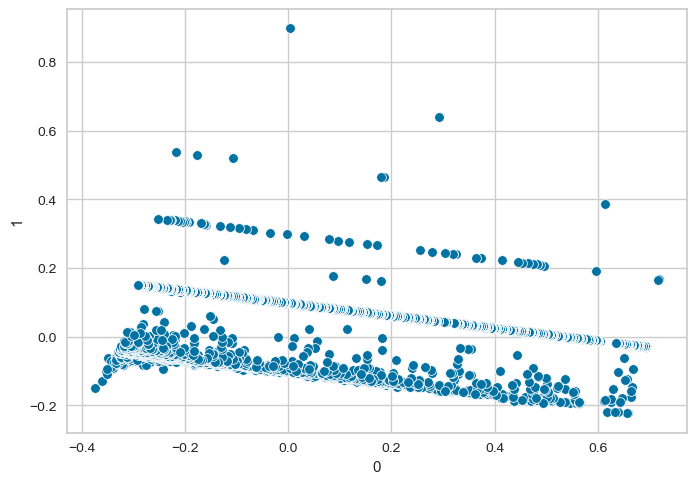

In [28]:
# plotando todos os dados no plano das duas primeiras componentes principais (PC1, PC2)
df_pca = pd.DataFrame(principal_components)
sns.scatterplot(x=0, y=1, data=df_pca)

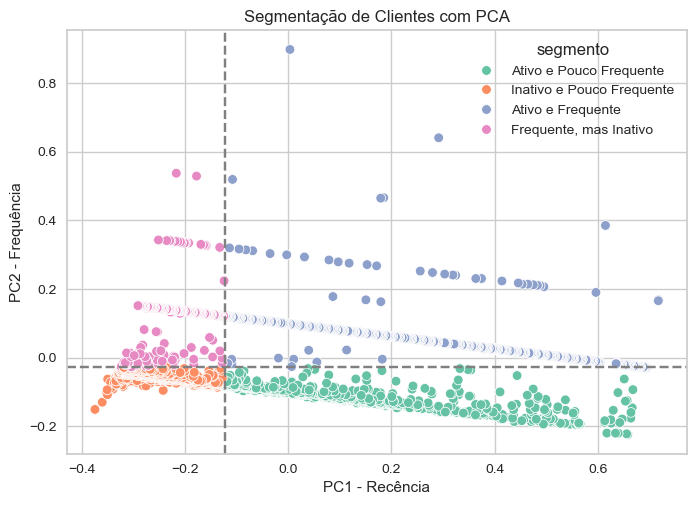

In [60]:
# criando segmentos com base na mediana
PC1 = 0
PC2 = 1
pc1_median = df_pca[PC1].median()
pc2_median = df_pca[PC2].median()

def segmentar_cliente(row):
    if row[PC1] >= pc1_median and row[PC2] >= pc2_median:
        return 'Ativo e Frequente'
    elif row[PC1] < pc1_median and row[PC2] >= pc2_median:
        return 'Frequente, mas Inativo'
    elif row[PC1] < pc1_median and row[PC2] < pc2_median:
        return 'Inativo e Pouco Frequente'
    else:
        return 'Ativo e Pouco Frequente'  # pode também indicar um cliente novo

df_pca['segmento'] = df_pca.apply(segmentar_cliente, axis=1)

sns.scatterplot(data=df_pca, x=PC1, y=PC2, hue='segmento', palette='Set2')
plt.axvline(x=pc1_median, color='gray', linestyle='--')
plt.axhline(y=pc2_median, color='gray', linestyle='--')
plt.title('Segmentação de Clientes com PCA')
plt.xlabel('PC1 - Recência')
plt.ylabel('PC2 - Frequência')
plt.grid(True)
plt.show()

In [61]:
df_pca.head()

0         1                   segmento
0  0.665944 -0.145861    Ativo e Pouco Frequente
1 -0.182492 -0.081758  Inativo e Pouco Frequente
2 -0.322944 -0.047678  Inativo e Pouco Frequente
3 -0.075241 -0.087065    Ativo e Pouco Frequente
4  0.554757 -0.185192    Ativo e Pouco Frequente

In [62]:
# calculando valores médios das features para os segmentos:
df_enriquecido = df_pca.copy()
df_enriquecido['segmento'] = df_pca['segmento']

resumo_segmentos = df_enriquecido.groupby('segmento').agg({
    0: 'mean',
    1: 'mean'
}).round(5).sort_values(0, ascending=False)

resumo_segmentos

0        1
segmento                                   
Ativo e Frequente          0.29070  0.04964
Ativo e Pouco Frequente    0.12850 -0.11365
Frequente, mas Inativo    -0.21344  0.12635
Inativo e Pouco Frequente -0.25899 -0.05438

In [63]:
# análise preliminar dos perfis de clientes para cada segmento:
Ativo e Frequente
    Alta receita, baixa recência, alta frequência.
    Perfil ideal: clientes fiéis e valiosos.
    Estratégia: manter o engajamento com recompensas.

Frequente, mas Inativo
    Gastam bem, mas não compram há muito tempo.
    Muitas devoluções: talvez insatisfação.
    Estratégia: reativação e escuta ativa (NPS, atendimento).

Ativo e Pouco Frequente (também há possibilidade de ser um cliente novo)
    Compraram recentemente, mas pouco.
    Potencial de crescimento.
    Estratégia: campanhas de onboarding e incentivo.

Inativo e Pouco Frequente
    Baixo valor, sem atividade recente.
    Pouco retorno esperado.
    Estratégia: campanha automatizada, ou foco em novos perfis.

SyntaxError: invalid syntax (2501817015.py, line 2)

#### 5.3.2 **UMAP (Uniform Manifold Approximation and Projection)**

In [ ]:
# para aplicar o umap, também é preciso padronizar os dados (já feito no início da seção Estudo do espaço)

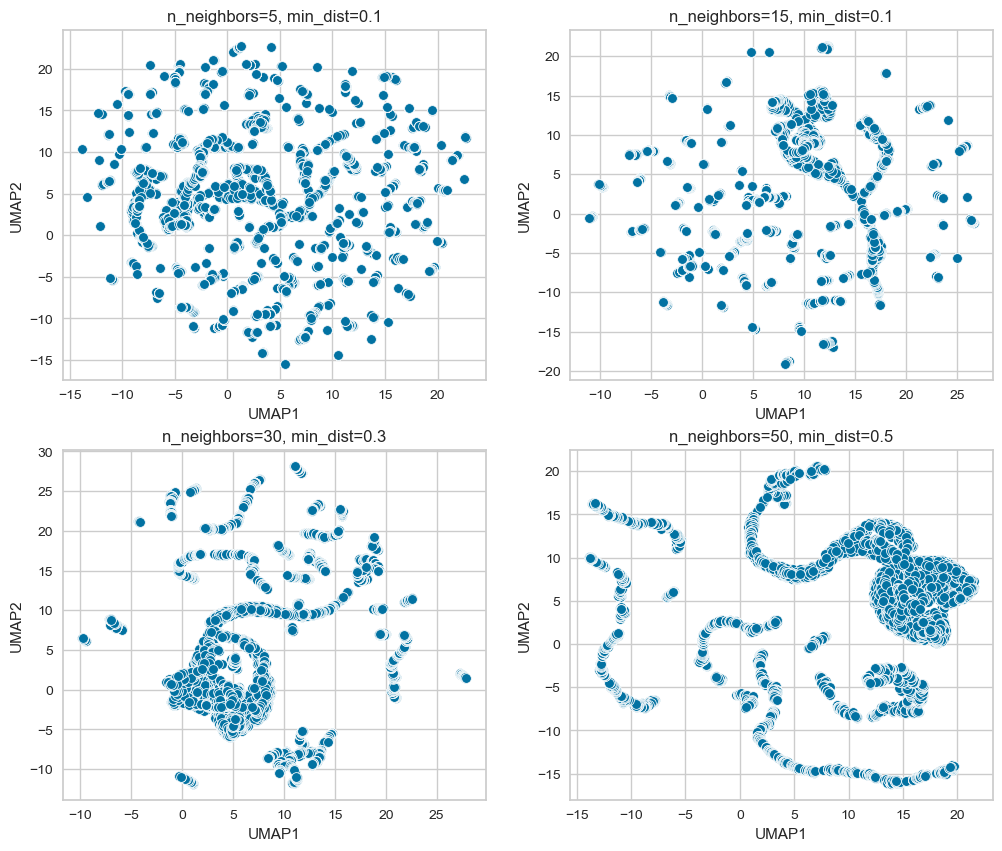

In [31]:
params_umap = [(5, 0.1), (15, 0.1), (30, 0.3), (50, 0.5)]
fig, axes = plt.subplots(2, 2, figsize=(12,10))

for (n, d), ax in zip(params_umap, axes.flatten()):
    reducer = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2, random_state=42)
    embedding = reducer.fit_transform(X)
    df_plot = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
    sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', ax=ax, palette='tab10')
    ax.set_title(f'n_neighbors={n}, min_dist={d}')

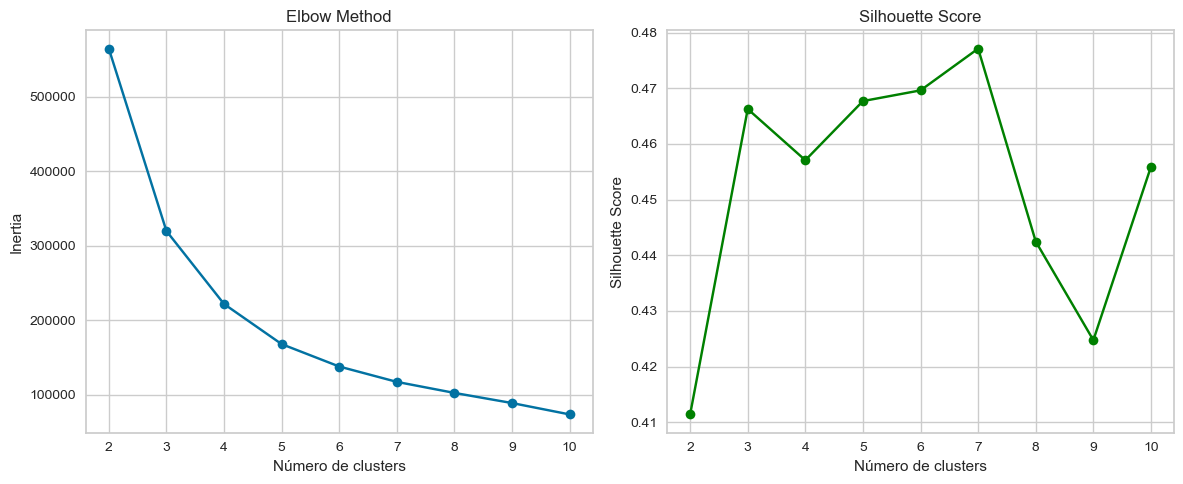

In [29]:
# fazendo o umap com o 'melhor' par de parâmetros e depois aplicando o kmeans sobre esses dados
# as técnicas elbow method e silhouette score também são aplicadas

umap_reducer = umap.UMAP(n_neighbors=50, min_dist=0.5, n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X)

inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = c.KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_umap)

    inertia = kmeans.inertia_
    sil_score = mt.silhouette_score(X_umap, labels)

    inertias.append(inertia)
    silhouette_scores.append(sil_score)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(k_range, inertias, marker='o')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Número de clusters')
ax[0].set_ylabel('Inertia')

ax[1].plot(k_range, silhouette_scores, marker='o', color='green')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('Número de clusters')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

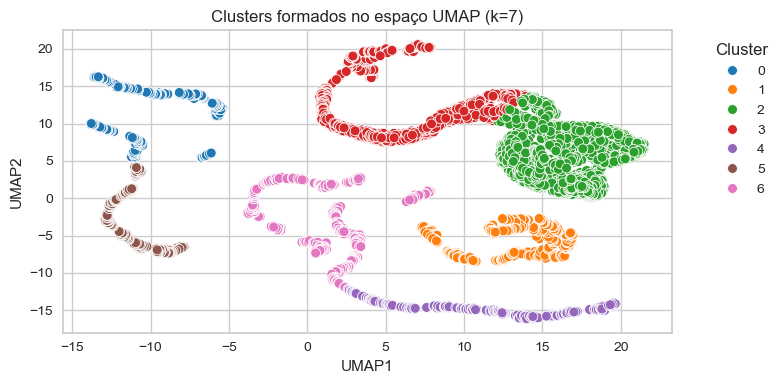

In [66]:
# com o resultado do elbow method e do silhouette score, foi escolhido k=7
# o umap e o kmeans são aplicados (idem ao feito acima) usando esse número de clusters k

umap_reducer = umap.UMAP(n_neighbors=50, min_dist=0.5, n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X)

kmeans = c.KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(X_umap)

# usando os labels gerados pelo kmeans (labels = a qual cluster pertence a linha do df)
df_plot = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_plot['cluster'] = clusters

plt.figure(figsize=(8, 4))
sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='cluster', palette='tab10', s=50)
plt.title('Clusters formados no espaço UMAP (k=7)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### 5.3.3 **t-SNE (t-distributed Stochastic Neighbor Embedding)**

In [ ]:
# o t-SNE também precisa de valores padronizados

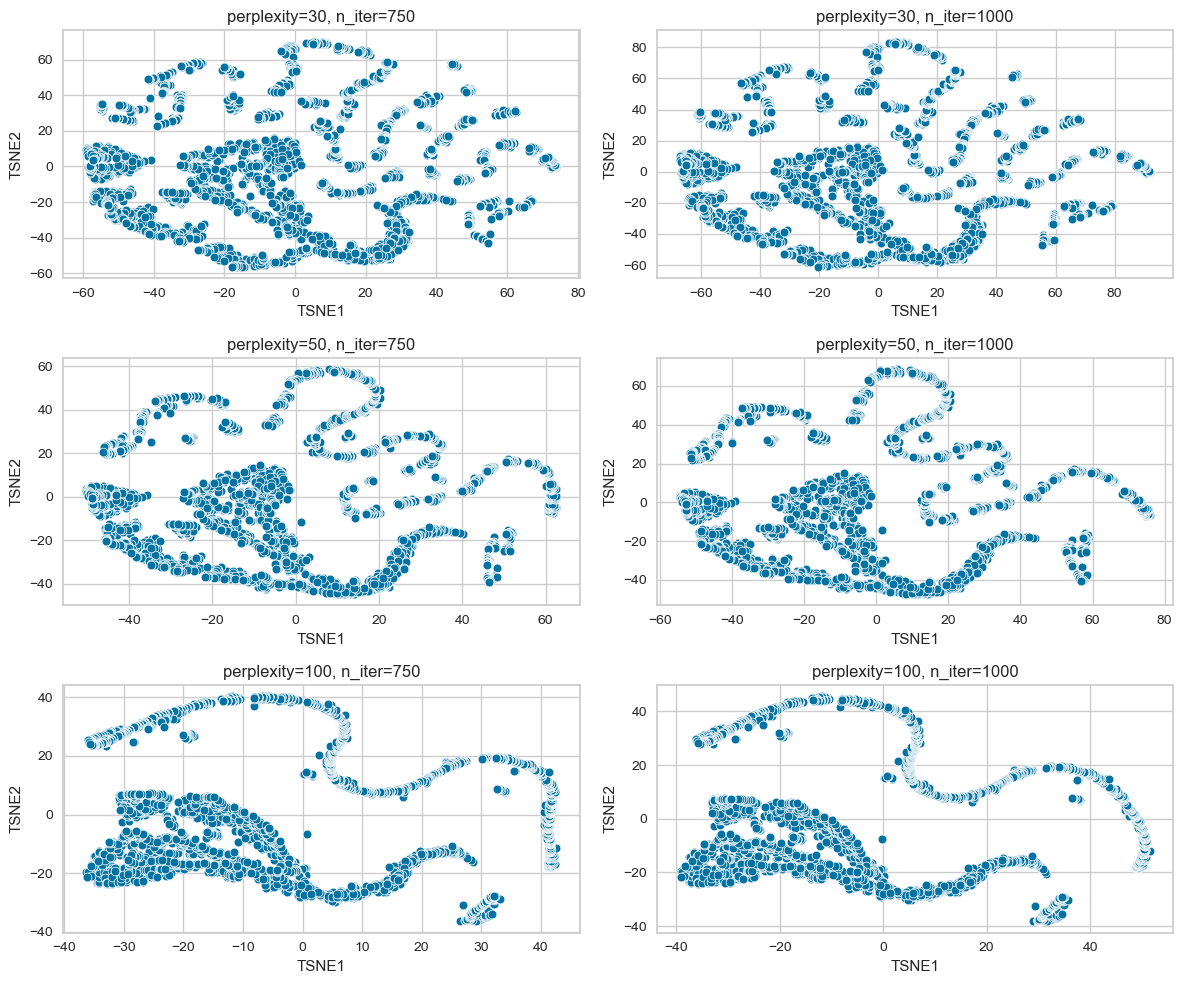

In [30]:
perplexities = [30, 50, 100]
n_iters = [750, 1000]

fig, axes = plt.subplots(len(perplexities), len(n_iters), figsize=(12, 10))

for i, p in enumerate(perplexities):
    for j, n in enumerate(n_iters):
        tsne = mn.TSNE(n_components=2, perplexity=p, n_iter=n, random_state=42)
        tsne_result = tsne.fit_transform(X)
        
        df_tsne = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
        
        ax = axes[i, j]
        sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', palette='tab10', s=40, ax=ax, legend=False)
        ax.set_title(f'perplexity={p}, n_iter={n}')
        
plt.tight_layout()
plt.show()

#### 5.3.4 **Tree-based embedding** 

In [ ]:
# ao usar um algoritmo de árvore para fazer o embbeding é como se 'transformássemos' o problema em um supervisionado
# para isso, precisamos de uma variável alvo (para esse problema de negócio, foi escolhido o 'gross_revenue')
# o modelo é treinado normalmente e, depois, criamos um dataframe (df_leaf) com as posições geradas por cada folha
# é sobre esse 'espaço' que vamos fazer o umap

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

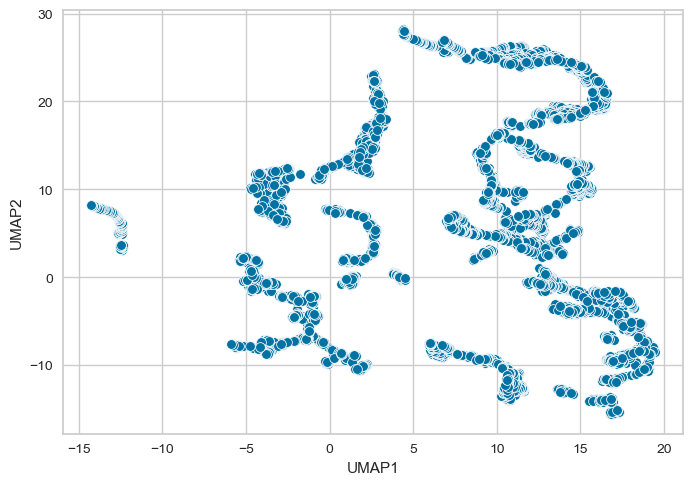

In [31]:
X = df4.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

df_leaf = pd.DataFrame(rf_model.apply(X))

reducer_tree = umap.UMAP(n_neighbors=50, min_dist=0.5, n_components=2, random_state=42)
embedding_tree = reducer_tree.fit_transform(df_leaf)

df_tree = pd.DataFrame(embedding_tree, columns=['UMAP1', 'UMAP2'])
sns.scatterplot(data=df_tree, x='UMAP1', y='UMAP2')

In [ ]:
# aqui, vemos os clusters facilmente. aparentemente, uns 7, 8 clusters

# 6.0 Data Preparation

In [32]:
df5 = df4.copy()

In [33]:
mm = pp.MinMaxScaler()

df5['gross_revenue']     = mm.fit_transform(df5[['gross_revenue']])
df5['recency_days']      = mm.fit_transform(df5[['recency_days']])
df5['frequency']         = mm.fit_transform(df5[['frequency']])
df5['qtde_prod_returns'] = mm.fit_transform(df5[['qtde_prod_returns']])
df5['qtde_invoices']     = mm.fit_transform(df5[['qtde_invoices']])
df5['qtde_products']     = mm.fit_transform(df5[['qtde_products']])
df5['qtde_returns']      = mm.fit_transform(df5[['qtde_returns']])

# 7.0 Hyperparameter fine-tuning

In [34]:
X = df5.drop(columns=['customer_id']).copy()

In [ ]:
# analisar os df gerados pelos embeddings para decidir se será melhor usar algum deles ou o df original

In [35]:
pca = dd.PCA(n_components=2)
X_pca = pca.fit_transform(X)

umap_reducer = umap.UMAP(n_neighbors=50, min_dist=0.5, n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X)

tsne_model = mn.TSNE(n_components=2, perplexity=50, n_iter=750, random_state=42)
X_tsne = tsne_model.fit_transform(X)

In [ ]:
# avaliação visual dos rótulos gerados pelos embeddings:

In [37]:
# usando kmeans:
kmeans_pca = c.KMeans(n_clusters=7, random_state=42).fit(X_pca)
kmeans_umap = c.KMeans(n_clusters=7, random_state=42).fit(X_umap)
kmeans_tsne = c.KMeans(n_clusters=7, random_state=42).fit(X_tsne)

# usando hierarchical clustering:
hc_pca = c.AgglomerativeClustering(n_clusters=7, linkage='ward').fit(X_pca)
hc_umap = c.AgglomerativeClustering(n_clusters=7, linkage='ward').fit(X_umap)
hc_tsne = c.AgglomerativeClustering(n_clusters=7, linkage='ward').fit(X_tsne)

In [38]:
df_plot_kmeans = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'UMAP1': X_umap[:, 0],
    'UMAP2': X_umap[:, 1],
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'cluster_pca': kmeans_pca.labels_,
    'cluster_umap': kmeans_umap.labels_,
    'cluster_tsne': kmeans_tsne.labels_,})

df_plot_hc = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'UMAP1': X_umap[:, 0],
    'UMAP2': X_umap[:, 1],
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'cluster_pca': hc_pca.labels_,
    'cluster_umap': hc_umap.labels_,
    'cluster_tsne': hc_tsne.labels_,})

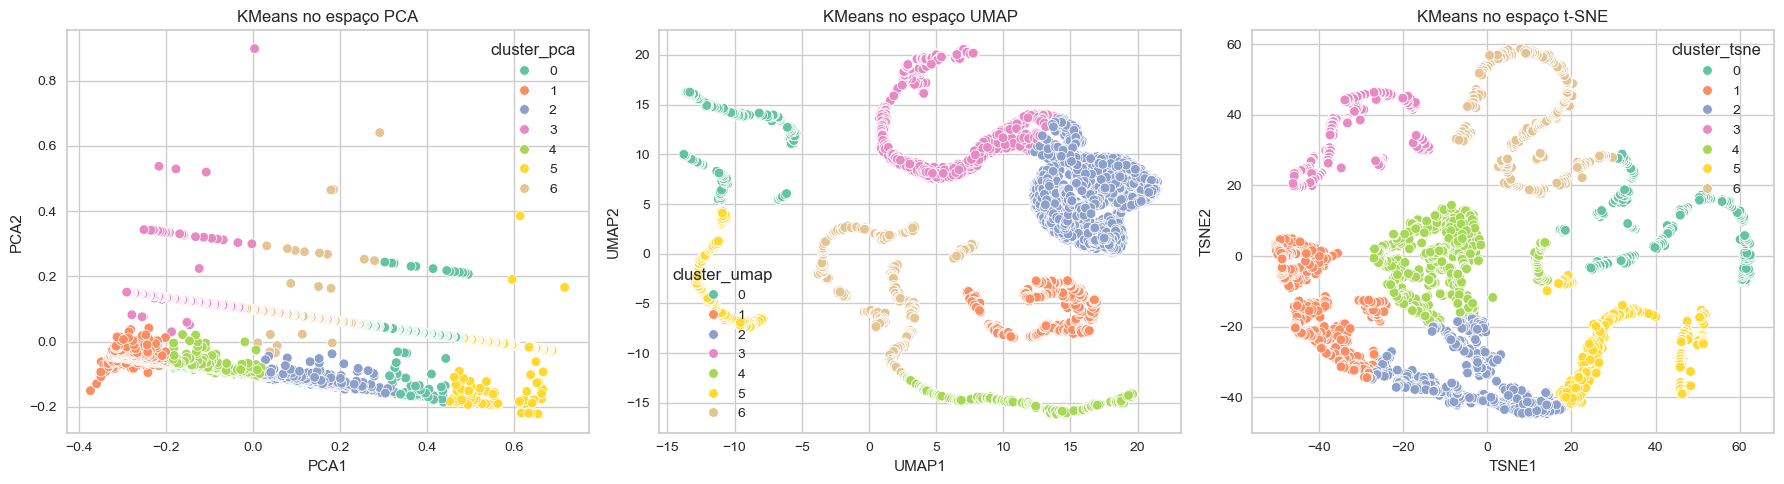

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_pca', palette='Set2', data=df_plot_kmeans, ax=axes[0])
axes[0].set_title('KMeans no espaço PCA')

sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster_umap', palette='Set2', data=df_plot_kmeans, ax=axes[1])
axes[1].set_title('KMeans no espaço UMAP')

sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster_tsne', palette='Set2', data=df_plot_kmeans, ax=axes[2])
axes[2].set_title('KMeans no espaço t-SNE')

plt.tight_layout()
plt.show()

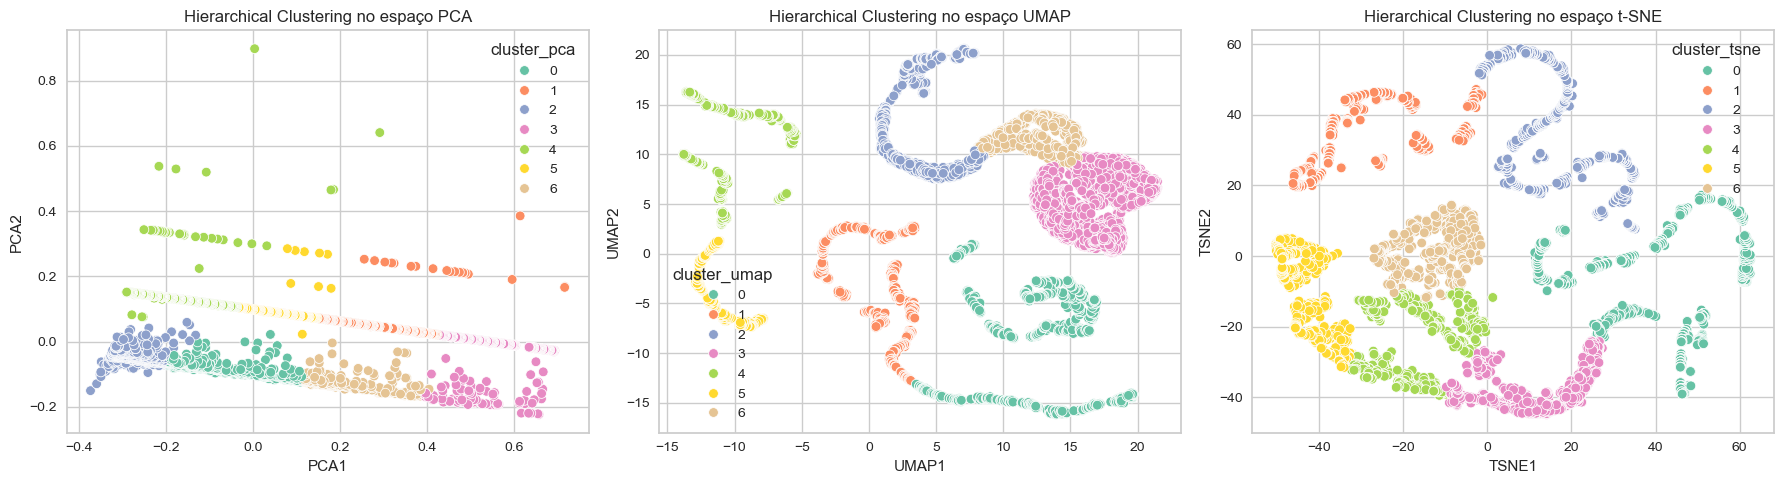

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_pca', palette='Set2', data=df_plot_hc, ax=axes[0])
axes[0].set_title('Hierarchical Clustering no espaço PCA')

sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster_umap', palette='Set2', data=df_plot_hc, ax=axes[1])
axes[1].set_title('Hierarchical Clustering no espaço UMAP')

sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster_tsne', palette='Set2', data=df_plot_hc, ax=axes[2])
axes[2].set_title('Hierarchical Clustering no espaço t-SNE')

plt.tight_layout()
plt.show()

In [41]:
# para o Kmeans:
metrics = {
    'PCA': {
        'Silhouette (PCA space)': mt.silhouette_score(X_pca, kmeans_pca.labels_),
        'Silhouette (original space)': mt.silhouette_score(X, kmeans_pca.labels_),
        'Calinski-Harabasz (PCA space)': mt.calinski_harabasz_score(X_pca, kmeans_pca.labels_),
        'Calinski-Harabasz (original space)': mt.calinski_harabasz_score(X, kmeans_pca.labels_),
        'Davies-Bouldin (PCA space)': mt.davies_bouldin_score(X_pca, kmeans_pca.labels_),
        'Davies-Bouldin (original space)': mt.davies_bouldin_score(X, kmeans_pca.labels_),    },
    'UMAP': {
        'Silhouette (UMAP space)': mt.silhouette_score(X_umap, kmeans_umap.labels_),
        'Silhouette (original space)': mt.silhouette_score(X, kmeans_umap.labels_),
        'Calinski-Harabasz (UMAP space)': mt.calinski_harabasz_score(X_umap, kmeans_umap.labels_),
        'Calinski-Harabasz (original space)': mt.calinski_harabasz_score(X, kmeans_umap.labels_),
        'Davies-Bouldin (UMAP space)': mt.davies_bouldin_score(X_umap, kmeans_umap.labels_),
        'Davies-Bouldin (original space)': mt.davies_bouldin_score(X, kmeans_umap.labels_),    },
    't-SNE': {
        'Silhouette (t-SNE space)': mt.silhouette_score(X_tsne, kmeans_tsne.labels_),
        'Silhouette (original space)': mt.silhouette_score(X, kmeans_tsne.labels_),
        'Calinski-Harabasz (t-SNE space)': mt.calinski_harabasz_score(X_tsne, kmeans_tsne.labels_),
        'Calinski-Harabasz (original space)': mt.calinski_harabasz_score(X, kmeans_tsne.labels_),
        'Davies-Bouldin (t-SNE space)': mt.davies_bouldin_score(X_tsne, kmeans_tsne.labels_),
        'Davies-Bouldin (original space)': mt.davies_bouldin_score(X, kmeans_tsne.labels_),    }}

In [42]:
# para o Hierarchical Clustering:
metrics_hc = {
    'PCA': {
        'Silhouette (PCA space)': mt.silhouette_score(X_pca, hc_pca.labels_),
        'Silhouette (original space)': mt.silhouette_score(X, hc_pca.labels_),
        'Calinski-Harabasz (PCA space)': mt.calinski_harabasz_score(X_pca, hc_pca.labels_),
        'Calinski-Harabasz (original space)': mt.calinski_harabasz_score(X, hc_pca.labels_),
        'Davies-Bouldin (PCA space)': mt.davies_bouldin_score(X_pca, hc_pca.labels_),
        'Davies-Bouldin (original space)': mt.davies_bouldin_score(X, hc_pca.labels_),    },
    'UMAP': {
        'Silhouette (UMAP space)': mt.silhouette_score(X_umap, hc_umap.labels_),
        'Silhouette (original space)': mt.silhouette_score(X, hc_umap.labels_),
        'Calinski-Harabasz (UMAP space)': mt.calinski_harabasz_score(X_umap, hc_umap.labels_),
        'Calinski-Harabasz (original space)': mt.calinski_harabasz_score(X, hc_umap.labels_),
        'Davies-Bouldin (UMAP space)': mt.davies_bouldin_score(X_umap, hc_umap.labels_),
        'Davies-Bouldin (original space)': mt.davies_bouldin_score(X, hc_umap.labels_),   },
    't-SNE': {
        'Silhouette (t-SNE space)': mt.silhouette_score(X_tsne, hc_tsne.labels_),
        'Silhouette (original space)': mt.silhouette_score(X, hc_tsne.labels_),
        'Calinski-Harabasz (t-SNE space)': mt.calinski_harabasz_score(X_tsne, hc_tsne.labels_),
        'Calinski-Harabasz (original space)': mt.calinski_harabasz_score(X, hc_tsne.labels_),
        'Davies-Bouldin (t-SNE space)': mt.davies_bouldin_score(X_tsne, hc_tsne.labels_),
        'Davies-Bouldin (original space)': mt.davies_bouldin_score(X, hc_tsne.labels_),    }}

In [43]:
dados = {
    'Silhouette': [
        metrics['PCA']['Silhouette (PCA space)'],
        metrics['PCA']['Silhouette (original space)'],
        metrics['UMAP']['Silhouette (UMAP space)'],
        metrics['UMAP']['Silhouette (original space)'],
        metrics['t-SNE']['Silhouette (t-SNE space)'],
        metrics['t-SNE']['Silhouette (original space)']    ],
    'Calinski-Harabasz': [
        metrics['PCA']['Calinski-Harabasz (PCA space)'],
        metrics['PCA']['Calinski-Harabasz (original space)'],
        metrics['UMAP']['Calinski-Harabasz (UMAP space)'],
        metrics['UMAP']['Calinski-Harabasz (original space)'],
        metrics['t-SNE']['Calinski-Harabasz (t-SNE space)'],
        metrics['t-SNE']['Calinski-Harabasz (original space)']    ],
    'Davies-Bouldin': [
        metrics['PCA']['Davies-Bouldin (PCA space)'],
        metrics['PCA']['Davies-Bouldin (original space)'],
        metrics['UMAP']['Davies-Bouldin (UMAP space)'],
        metrics['UMAP']['Davies-Bouldin (original space)'],
        metrics['t-SNE']['Davies-Bouldin (t-SNE space)'],
        metrics['t-SNE']['Davies-Bouldin (original space)']    ]}

df_formatado = pd.DataFrame(dados, 
    index=['PCA space', 'No espaço original', 'UMAP space', 'No espaço original', 't-SNE space', 'No espaço original']
    ).T.round(3)

df_formatado

PCA space  No espaço original  UMAP space  \
Silhouette             0.569               0.493       0.477   
Calinski-Harabasz  17113.275            9802.099    6677.150   
Davies-Bouldin         0.614               0.699       0.739   

                   No espaço original  t-SNE space  No espaço original  
Silhouette                      0.307        0.445               0.203  
Calinski-Harabasz            2680.341     6357.984            3009.214  
Davies-Bouldin                  1.246        0.749               2.099

In [44]:
dados_hc = {
    'Silhouette': [
        metrics_hc['PCA']['Silhouette (PCA space)'],
        metrics_hc['PCA']['Silhouette (original space)'],
        metrics_hc['UMAP']['Silhouette (UMAP space)'],
        metrics_hc['UMAP']['Silhouette (original space)'],
        metrics_hc['t-SNE']['Silhouette (t-SNE space)'],
        metrics_hc['t-SNE']['Silhouette (original space)']    ],
    'Calinski-Harabasz': [
        metrics_hc['PCA']['Calinski-Harabasz (PCA space)'],
        metrics_hc['PCA']['Calinski-Harabasz (original space)'],
        metrics_hc['UMAP']['Calinski-Harabasz (UMAP space)'],
        metrics_hc['UMAP']['Calinski-Harabasz (original space)'],
        metrics_hc['t-SNE']['Calinski-Harabasz (t-SNE space)'],
        metrics_hc['t-SNE']['Calinski-Harabasz (original space)']    ],
    'Davies-Bouldin': [
        metrics_hc['PCA']['Davies-Bouldin (PCA space)'],
        metrics_hc['PCA']['Davies-Bouldin (original space)'],
        metrics_hc['UMAP']['Davies-Bouldin (UMAP space)'],
        metrics_hc['UMAP']['Davies-Bouldin (original space)'],
        metrics_hc['t-SNE']['Davies-Bouldin (t-SNE space)'],
        metrics_hc['t-SNE']['Davies-Bouldin (original space)']    ]}

df_formatado_hc = pd.DataFrame(dados_hc, 
    index=['PCA space', 'No espaço original', 'UMAP space', 'No espaço original', 't-SNE space', 'No espaço original']
    ).T.round(3)

df_formatado_hc

PCA space  No espaço original  UMAP space  \
Silhouette             0.550               0.485       0.426   
Calinski-Harabasz  14722.345            8938.425    6326.898   
Davies-Bouldin         0.646               0.710       0.781   

                   No espaço original  t-SNE space  No espaço original  
Silhouette                      0.359        0.387               0.325  
Calinski-Harabasz            4602.575     5079.638            6299.539  
Davies-Bouldin                  1.372        0.800               1.072

In [ ]:
# baseando nos resultados acima, o PCA apresentou melhores resultados tanto no kmeans quanto no
# hierarchical clustering. no kmeans, os resultados foram ligeiramente melhores.

In [ ]:
# a análise dos resultados será através das métricas:
# SS --> combina coesão interna e separação entre clusters -> mais próximo de 1, melhor
# DBI --> mede a "semelhança" entre clusters, penalizando sobreposição -> mais próximo de zero, melhor
# CHI --> razão entre dispersão entre clusters / dentro dos clusters -> maior valor, melhor

# SS: Silhouette Score
# DBI: Davies-Bouldin Index	
# CHI: Calinski-Harabasz Index

#### 7.1 **GMM (Gaussian Mixture Model)**

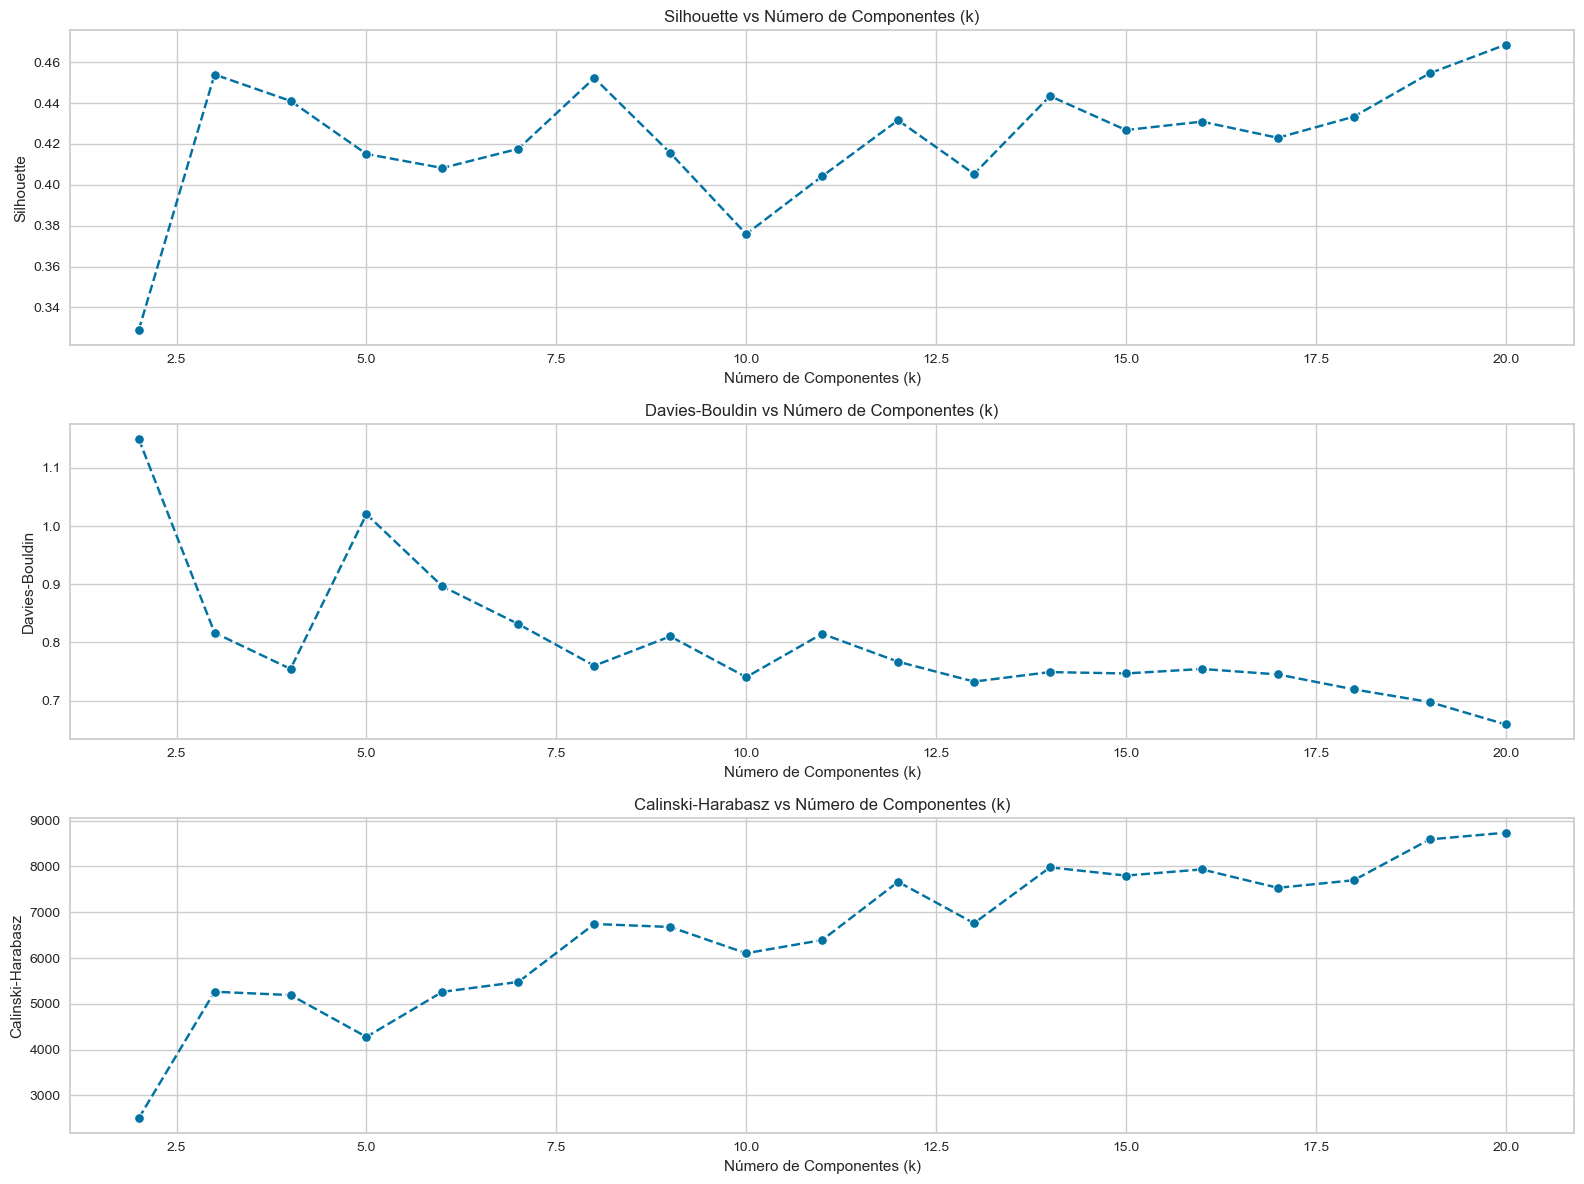

In [53]:
k_range = np.arange(2, 21)
results_gmm = []

for k in k_range:
    gmm = mx.GaussianMixture(n_components=k, n_init=10, random_state=42)
    labels = gmm.fit_predict(X_umap)

    if len(set(labels)) > 1:
        result = {
            'k': k,
            'Silhouette': mt.silhouette_score(X_umap, labels),
            'Davies-Bouldin': mt.davies_bouldin_score(X_umap, labels),
            'Calinski-Harabasz': mt.calinski_harabasz_score(X_umap, labels)
        }
        results_gmm.append(result)

df_gmm_all = pd.DataFrame(results_gmm)

metrics = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']

plt.figure(figsize=(16, 12))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 1, i)
    sns.lineplot(data=df_gmm_all, x='k', y=metric, marker='o', linestyle='--')
    plt.title(f'{metric} vs Número de Componentes (k)')
    plt.xlabel('Número de Componentes (k)')
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# gmm acima para o conjunto de dados que apresentou a melhor silhouette para 7, 8 clusters
# dados testados: X, X_pca, X_umap, X_tsne

#### 7.2 **DBSCAN**

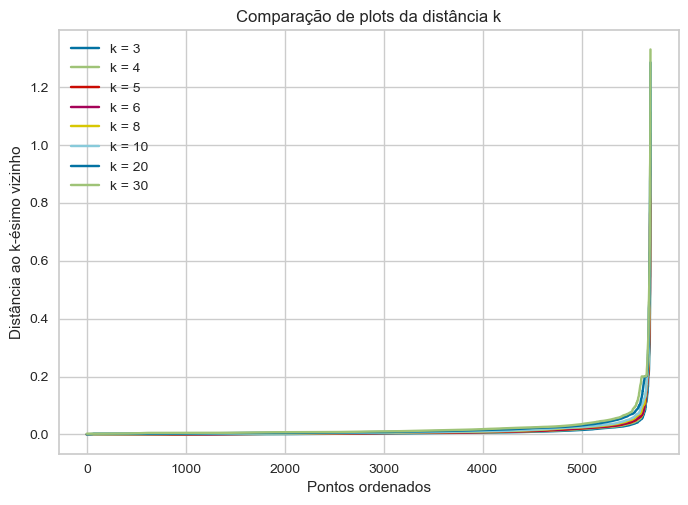

In [39]:
for min_samples in [3, 4, 5, 6, 8, 10, 20, 30]:
    
    neigh = ne.NearestNeighbors(n_neighbors=min_samples).fit(X)    # calcula distância até o k-ésimo vizinho
    dists, _ = neigh.kneighbors(X)
    k_dists = np.sort(dists[:, min_samples - 1])
    
    plt.plot(k_dists, label=f'k = {min_samples}')
    
plt.title('Comparação de plots da distância k')
plt.xlabel('Pontos ordenados')
plt.ylabel('Distância ao k-ésimo vizinho')
plt.legend()
plt.grid(True)
plt.show()

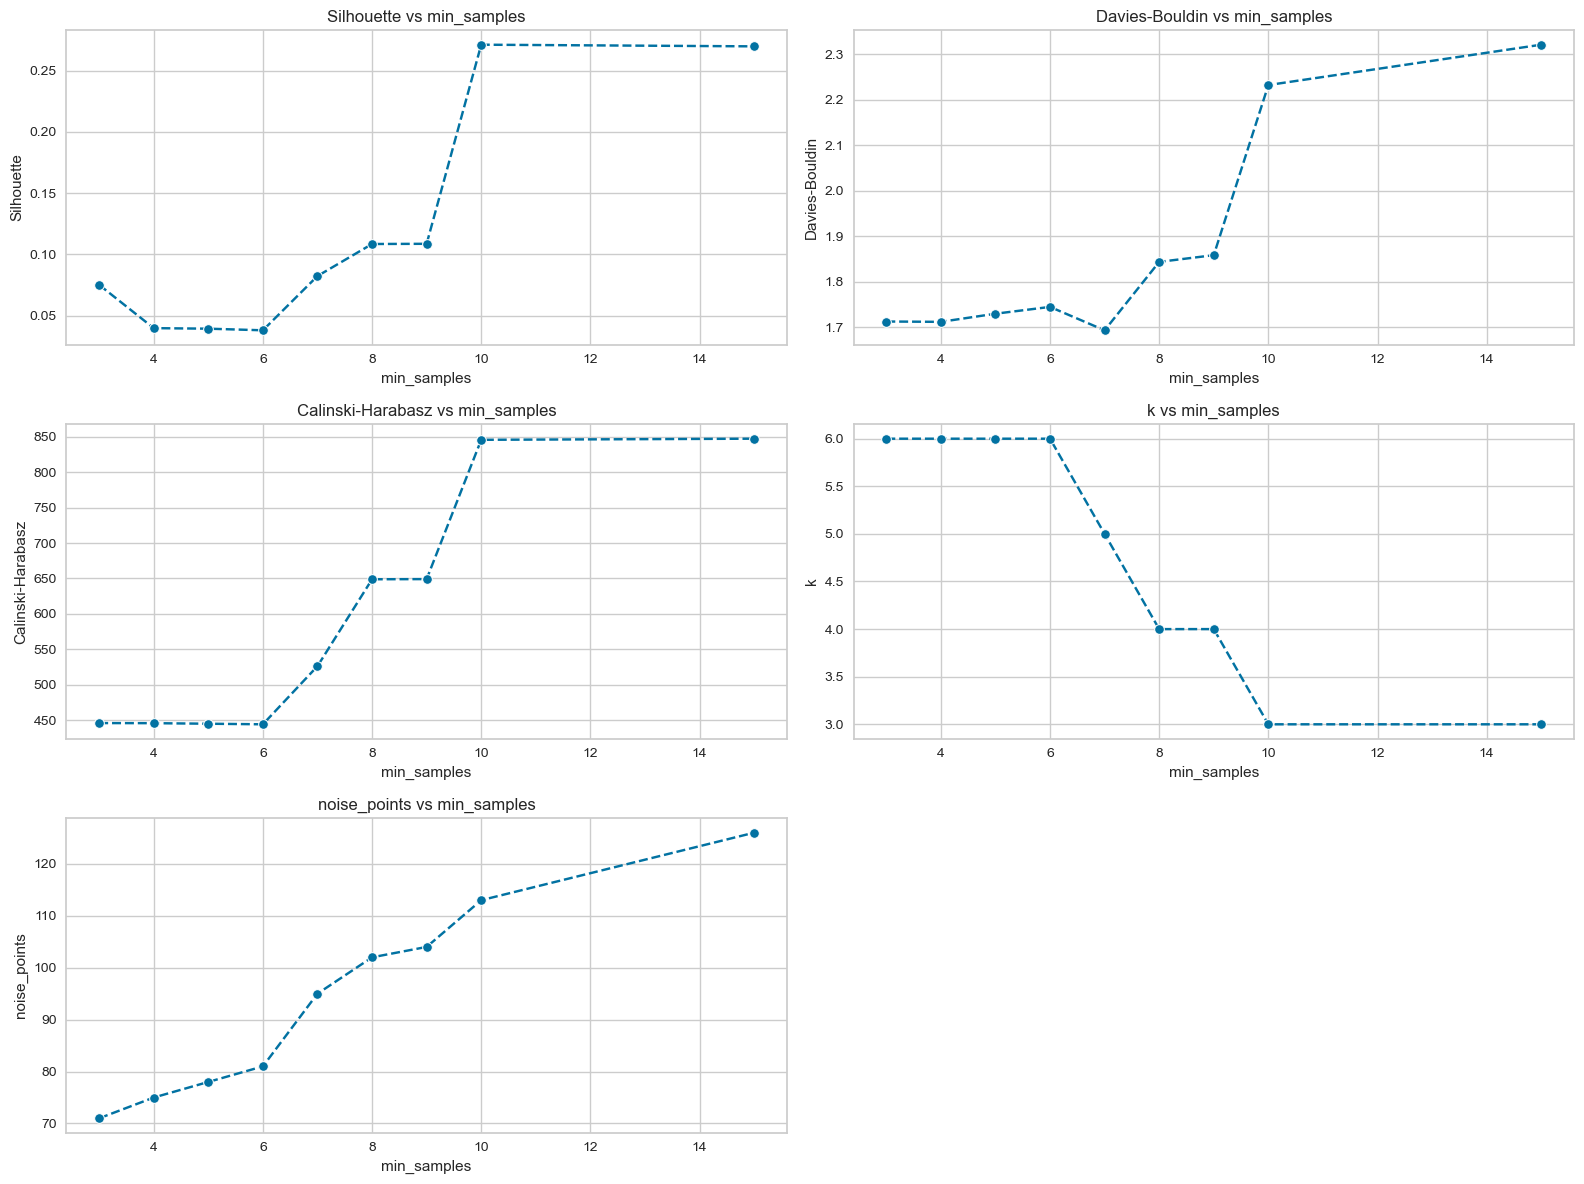

In [61]:
min_samples_values = [3, 4, 5, 6, 7, 8, 9, 10, 15]
results_dbscan = []

for min_samples in min_samples_values:
    dbscan = c.DBSCAN(eps=0.06, min_samples=min_samples)
    labels = dbscan.fit_predict(X)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    if n_clusters > 1:  # Só calcula métricas se há mais de 1 cluster real
        result = {
            'min_samples': min_samples,   # adicionado para plotagem
            'eps': 0.06,                   # adicionado para plotagem
            'k': n_clusters,
            'noise_points': n_noise,
            'Silhouette': mt.silhouette_score(X, labels),
            'Davies-Bouldin': mt.davies_bouldin_score(X, labels),
            'Calinski-Harabasz': mt.calinski_harabasz_score(X, labels),
        }
        results_dbscan.append(result)
    else:
        print(f"[AVISO] Apenas {n_clusters} cluster(s) para min_samples = {min_samples} — resultado ignorado.")

df_dbscan_all = pd.DataFrame(results_dbscan)

metrics = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz', 'k', 'noise_points']

plt.figure(figsize=(16, 12))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    sns.lineplot(data=df_dbscan_all, x='min_samples', y=metric, marker='o', linestyle='--')
    plt.title(f'{metric} vs min_samples')
    plt.xlabel('min_samples')
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [58]:
eps_values = np.linspace(0.05, 1.0, 20)  
min_samples_values = [3, 4, 5, 6, 8, 10, 15, 20, 30]
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = c.DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        if n_clusters > 1:
            silhouette = mt.silhouette_score(X, labels)
            davies_bouldin = mt.davies_bouldin_score(X, labels)
            calinski_harabasz = mt.calinski_harabasz_score(X, labels)

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'noise_points': n_noise,
                'Silhouette': silhouette,
                'Davies-Bouldin': davies_bouldin,
                'Calinski-Harabasz': calinski_harabasz
            })

df_dbscan_grid = pd.DataFrame(results)
df_dbscan_grid_sorted = df_dbscan_grid.sort_values(by="Silhouette", ascending=False)
print(df_dbscan_grid_sorted.head(10))

     eps  min_samples  n_clusters  noise_points  Silhouette  Davies-Bouldin  \
17  0.15            3           2            27    0.393523        1.519648   
19  0.20            3           2            20    0.393323        1.518461   
7   0.05           20           2           207    0.307346        2.951834   
6   0.05           15           3           177    0.266047        2.591221   
18  0.15           15           2            37    0.221616        1.695774   
12  0.10            6           2            52    0.211499        2.151004   
11  0.10            5           2            52    0.211499        2.151004   
10  0.10            4           2            52    0.211499        2.151004   
8   0.05           30           3           223    0.154005        2.353061   
5   0.05           10           4           141    0.141705        1.979633   

    Calinski-Harabasz  
17          39.618624  
19          36.600185  
7         1255.751078  
6          857.609867  
18        

#### 7.3 **Analisando o 'espaço' tree**

In [ ]:
# ao usar um algoritmo de árvore para fazer o embbeding é como se 'transformássemos' o problema em um supervisionado
# para isso, precisamos de uma variável alvo (para esse problema de negócio, foi escolhido o 'gross_revenue')
# o modelo é treinado normalmente e, depois, criamos um dataframe (df_leaf) com as posições geradas por cada folha
# é sobre esse 'espaço' que vamos fazer o embedding

In [38]:
x = df5.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df5['gross_revenue']

rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x, y)
df_tree = pd.DataFrame(rf_model.apply(x))

tree_pca = dd.PCA(n_components=2, random_state=42).fit_transform(df_tree)
tree_umap = umap.UMAP(n_neighbors=50, min_dist=0.5, random_state=42).fit_transform(df_tree)
tree_tsne = mn.TSNE(n_components=2, perplexity=50, n_iter=750, random_state=42).fit_transform(df_tree)

In [39]:
kmeans_tree_pca = c.KMeans(n_clusters=7, random_state=42).fit(tree_pca)
kmeans_tree_umap = c.KMeans(n_clusters=7, random_state=42).fit(tree_umap)
kmeans_tree_tsne = c.KMeans(n_clusters=7, random_state=42).fit(tree_tsne)

hc_tree_pca = c.AgglomerativeClustering(n_clusters=7, linkage='ward').fit(tree_pca)
hc_tree_umap = c.AgglomerativeClustering(n_clusters=7, linkage='ward').fit(tree_umap)
hc_tree_tsne = c.AgglomerativeClustering(n_clusters=7, linkage='ward').fit(tree_tsne)

In [40]:
# para PCA:
ss_pca_kmeans = mt.silhouette_score(tree_pca, kmeans_tree_pca.labels_)
dbi_pca_kmeans = mt.davies_bouldin_score(tree_pca, kmeans_tree_pca.labels_)
ch_pca_kmeans = mt.calinski_harabasz_score(tree_pca, kmeans_tree_pca.labels_)

ss_pca_hc = mt.silhouette_score(tree_pca, hc_tree_pca.labels_)
dbi_pca_hc = mt.davies_bouldin_score(tree_pca, hc_tree_pca.labels_)
ch_pca_hc = mt.calinski_harabasz_score(tree_pca, hc_tree_pca.labels_)

resultados = pd.DataFrame({
    "SS": [ss_pca_kmeans, ss_pca_hc],
    "DBI": [dbi_pca_kmeans, dbi_pca_hc],
    "CH": [ch_pca_kmeans, ch_pca_hc]
}, index=["KMeans", "HC"])

print(resultados.round(3))

           SS    DBI         CH
KMeans  0.530  0.550  41708.506
HC      0.481  0.519  33273.037


In [41]:
# para UMAP:
ss_umap_kmeans = mt.silhouette_score(tree_umap, kmeans_tree_umap.labels_)
dbi_umap_kmeans = mt.davies_bouldin_score(tree_umap, kmeans_tree_umap.labels_)
ch_umap_kmeans = mt.calinski_harabasz_score(tree_umap, kmeans_tree_umap.labels_)

ss_umap_hc = mt.silhouette_score(tree_umap, hc_tree_umap.labels_)
dbi_umap_hc = mt.davies_bouldin_score(tree_umap, hc_tree_umap.labels_)
ch_umap_hc = mt.calinski_harabasz_score(tree_umap, hc_tree_umap.labels_)

resultados = pd.DataFrame({
    "SS": [ss_umap_kmeans, ss_umap_hc],
    "DBI": [dbi_umap_kmeans, dbi_umap_hc],
    "CH": [ch_umap_kmeans, ch_umap_hc]
}, index=["KMeans", "HC"])

print(resultados.round(3))

           SS    DBI        CH
KMeans  0.481  0.705  7716.007
HC      0.442  0.669  7088.996


In [42]:
# para t-SNE:
ss_tsne_kmeans = mt.silhouette_score(tree_tsne, kmeans_tree_tsne.labels_)
dbi_tsne_kmeans = mt.davies_bouldin_score(tree_tsne, kmeans_tree_tsne.labels_)
ch_tsne_kmeans = mt.calinski_harabasz_score(tree_tsne, kmeans_tree_tsne.labels_)

ss_tsne_hc = mt.silhouette_score(tree_tsne, hc_tree_tsne.labels_)
dbi_tsne_hc = mt.davies_bouldin_score(tree_tsne, hc_tree_tsne.labels_)
ch_tsne_hc = mt.calinski_harabasz_score(tree_tsne, hc_tree_tsne.labels_)

resultados = pd.DataFrame({
    "SS": [ss_tsne_kmeans, ss_tsne_hc],
    "DBI": [dbi_tsne_kmeans, dbi_tsne_hc],
    "CH": [ch_tsne_kmeans, ch_tsne_hc]
}, index=["KMeans", "HC"])

print(resultados.round(3))

           SS    DBI        CH
KMeans  0.411  0.775  5620.687
HC      0.381  0.808  4811.726


In [ ]:
# o embedding que apresentou a melhor performance foi o PCA (através do KMeans)

In [63]:
# usando os rótulos gerados pelo fit (depois de aplicado o embedding) e aplicando no dataframe original
tree_metrics_kmeans = {
    'PCA': {
        'Silhouette (PCA space)': mt.silhouette_score(tree_pca, kmeans_tree_pca.labels_),
        'Silhouette (original space)': mt.silhouette_score(X, kmeans_tree_pca.labels_),
        'Calinski-Harabasz (PCA space)': mt.calinski_harabasz_score(tree_pca, kmeans_tree_pca.labels_),
        'Calinski-Harabasz (original space)': mt.calinski_harabasz_score(X, kmeans_tree_pca.labels_),
        'Davies-Bouldin (PCA space)': mt.davies_bouldin_score(tree_pca, kmeans_tree_pca.labels_),
        'Davies-Bouldin (original space)': mt.davies_bouldin_score(X, kmeans_tree_pca.labels_),    }}

print(tree_metrics_kmeans)

{'PCA': {'Silhouette (PCA space)': 0.5298628201009579, 'Silhouette (original space)': -0.14736048351074543, 'Calinski-Harabasz (PCA space)': 41708.50591380442, 'Calinski-Harabasz (original space)': 216.5405044758163, 'Davies-Bouldin (PCA space)': 0.5496535241564094, 'Davies-Bouldin (original space)': 7.814030813629143}}


In [64]:
# usando os rótulos gerados pelo fit (depois de aplicado o embedding) e aplicando no dataframe advindo do 
# random forest (através das folhas das árvores)
tree_metrics_kmeans = {
    'PCA': {
        'Silhouette (PCA space)': mt.silhouette_score(tree_pca, kmeans_tree_pca.labels_),
        'Silhouette (tree space)': mt.silhouette_score(df_tree, kmeans_tree_pca.labels_),
        'Calinski-Harabasz (PCA space)': mt.calinski_harabasz_score(tree_pca, kmeans_tree_pca.labels_),
        'Calinski-Harabasz (tree space)': mt.calinski_harabasz_score(df_tree, kmeans_tree_pca.labels_),
        'Davies-Bouldin (PCA space)': mt.davies_bouldin_score(tree_pca, kmeans_tree_pca.labels_),
        'Davies-Bouldin (tree space)': mt.davies_bouldin_score(df_tree, kmeans_tree_pca.labels_),    }}

print(tree_metrics_kmeans)

{'PCA': {'Silhouette (PCA space)': 0.5298628201009579, 'Silhouette (original space)': 0.46062515668609433, 'Calinski-Harabasz (PCA space)': 41708.50591380442, 'Calinski-Harabasz (original space)': 31462.643363991963, 'Davies-Bouldin (PCA space)': 0.5496535241564094, 'Davies-Bouldin (original space)': 0.6884400170176963}}


#### 7.3.1 **GMM aplicado na 'tree'**

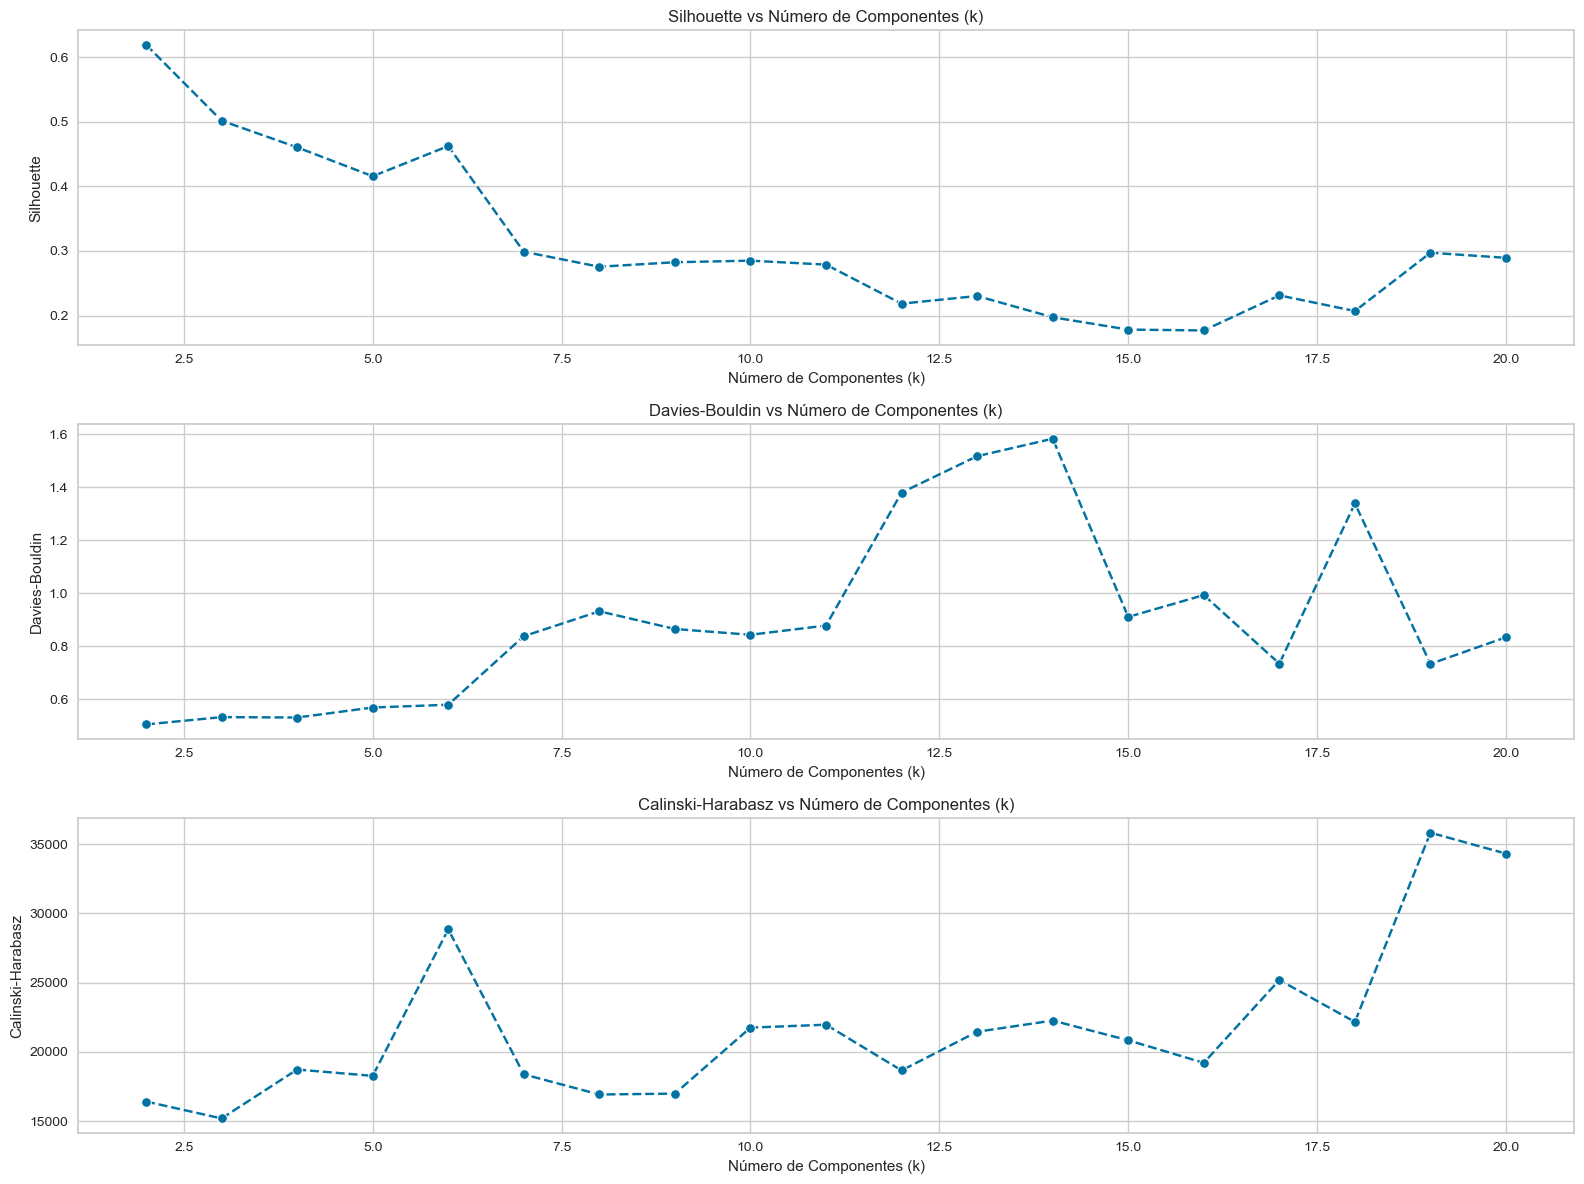

In [65]:
k_range = np.arange(2, 21)
results_gmm_tree = []

for k in k_range:
    gmm_tree = mx.GaussianMixture(n_components=k, n_init=10, random_state=42)
    labels = gmm_tree.fit_predict(tree_pca)

    if len(set(labels)) > 1:
        result = {
            'k': k,
            'Silhouette': mt.silhouette_score(tree_pca, labels),
            'Davies-Bouldin': mt.davies_bouldin_score(tree_pca, labels),
            'Calinski-Harabasz': mt.calinski_harabasz_score(tree_pca, labels)
        }
        results_gmm_tree.append(result)

df_gmm_all_tree = pd.DataFrame(results_gmm_tree)

metrics = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']

plt.figure(figsize=(16, 12))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 1, i)
    sns.lineplot(data=df_gmm_all_tree, x='k', y=metric, marker='o', linestyle='--')
    plt.title(f'{metric} vs Número de Componentes (k)')
    plt.xlabel('Número de Componentes (k)')
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
plt.show()

#### 7.3.2 **DBSCAN aplicado na 'tree'**

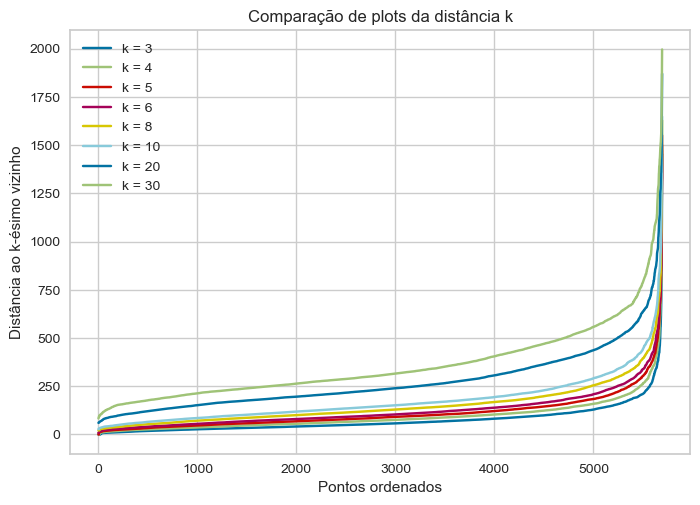

In [67]:
for min_samples in [3, 4, 5, 6, 8, 10, 20, 30]:
    
    neigh = ne.NearestNeighbors(n_neighbors=min_samples).fit(tree_pca)    # calcula distância até o k-ésimo vizinho
    dists, _ = neigh.kneighbors(tree_pca)
    k_dists = np.sort(dists[:, min_samples - 1])
    
    plt.plot(k_dists, label=f'k = {min_samples}')
    
plt.title('Comparação de plots da distância k')
plt.xlabel('Pontos ordenados')
plt.ylabel('Distância ao k-ésimo vizinho')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
eps_values = np.linspace(50, 1050, 50)  
min_samples_values = [3, 4, 5, 6, 8, 10, 15, 20, 25, 30]
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = c.DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(tree_pca)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        if n_clusters > 1:
            silhouette = mt.silhouette_score(tree_pca, labels)
            davies_bouldin = mt.davies_bouldin_score(tree_pca, labels)
            calinski_harabasz = mt.calinski_harabasz_score(tree_pca, labels)

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'noise_points': n_noise,
                'Silhouette': silhouette,
                'Davies-Bouldin': davies_bouldin,
                'Calinski-Harabasz': calinski_harabasz
            })

df_dbscan_grid = pd.DataFrame(results)
df_dbscan_grid_sorted = df_dbscan_grid.sort_values(by="Silhouette", ascending=False)
print(df_dbscan_grid_sorted.head(10))

            eps  min_samples  n_clusters  noise_points  Silhouette  \
263  580.612245           30           8           163    0.365505   
242  539.795918           25           8           142    0.365263   
293  641.836735           30           7           105    0.337204   
283  621.428571           30           7           108    0.335802   
262  580.612245           25           7           118    0.335059   
273  601.020408           30           7           140    0.335006   
252  560.204082           25           7           129    0.333156   
282  621.428571           25           6            95    0.324459   
253  560.204082           30           9           182    0.323827   
272  601.020408           25           6           111    0.323484   

     Davies-Bouldin  Calinski-Harabasz  
263        5.610484        4361.189390  
242        3.152520        4330.532831  
293        4.014006        3725.829850  
283        3.821754        3705.717212  
262        5.474772     

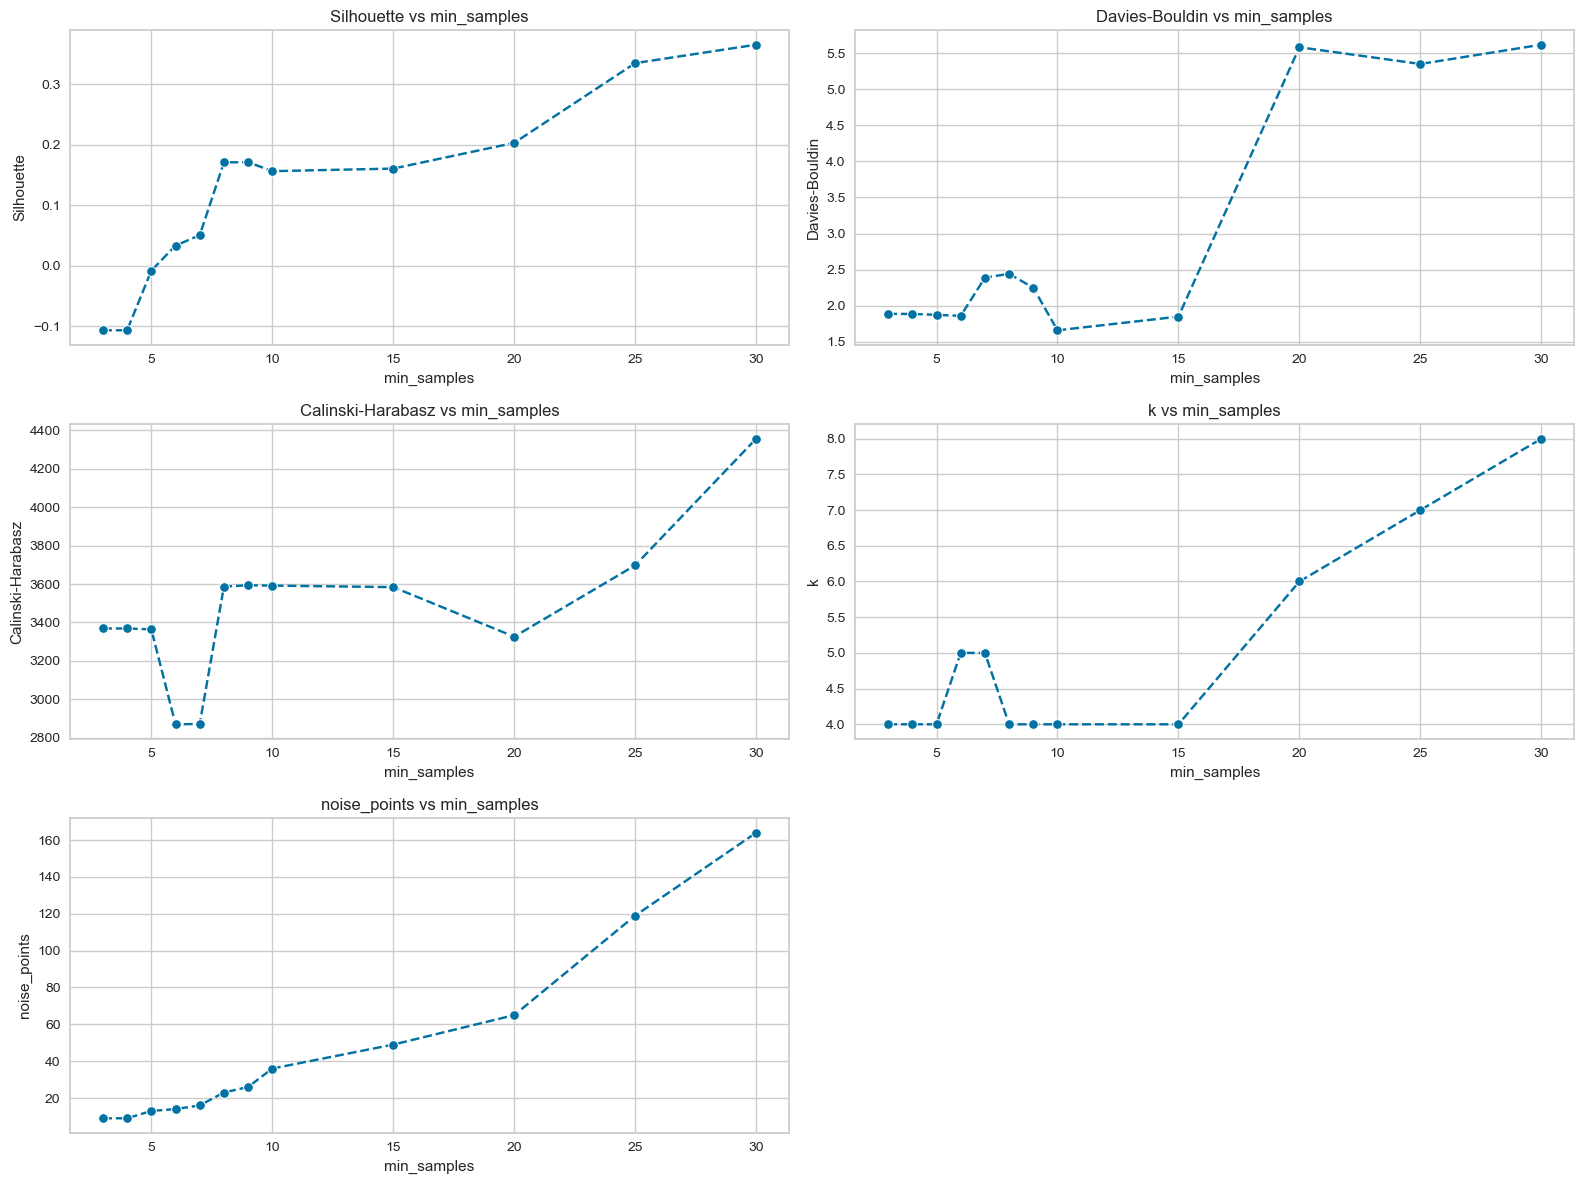

In [56]:
min_samples_values = [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]
results_dbscan = []

for min_samples in min_samples_values:
    dbscan = c.DBSCAN(eps=580, min_samples=min_samples)
    labels = dbscan.fit_predict(tree_pca)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    if n_clusters > 1:  # Só calcula métricas se há mais de 1 cluster real
        result = {
            'min_samples': min_samples,   # adicionado para plotagem
            'eps': 580,                   # adicionado para plotagem
            'k': n_clusters,
            'noise_points': n_noise,
            'Silhouette': mt.silhouette_score(tree_pca, labels),
            'Davies-Bouldin': mt.davies_bouldin_score(tree_pca, labels),
            'Calinski-Harabasz': mt.calinski_harabasz_score(tree_pca, labels),
        }
        results_dbscan.append(result)
    else:
        print(f"[AVISO] Apenas {n_clusters} cluster(s) para min_samples = {min_samples} — resultado ignorado.")

df_dbscan_all = pd.DataFrame(results_dbscan)

metrics = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz', 'k', 'noise_points']

plt.figure(figsize=(16, 12))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    sns.lineplot(data=df_dbscan_all, x='min_samples', y=metric, marker='o', linestyle='--')
    plt.title(f'{metric} vs min_samples')
    plt.xlabel('min_samples')
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# considerando as métricas ss, dbi e ch, as melhores performances foram:
# pca -> kmeans
# pca -> hc
# rf -> pca -> kmeans

# assim sendo, para esse ciclo, vou trabalhar com o pca -> kmeans para treinar o modelo.

# 8.0 Model training

In [ ]:
# baseando nos resultados da seção anterior, para uma análise inicial, vamos usar o K-means
# e o dataframe X_pca. novamente, considerando um cenário mais geral, menos de 10 clusters pode ser interessante,
# uma vez que não irá criar grupos específicos demais e, mais que 2 clusters para não ter grupos
# heterogêneos demais. usando essa limitação, o número de clusters k=7 apresenta boas métricas.

### 8.1 **K-Means**

In [69]:
k = 7
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
kmeans.fit(X_pca)
labels = kmeans.labels_

print('WSS value: {:.3f}'.format(kmeans.inertia_))
print('SS value: {:.3f}'.format(mt.silhouette_score(df_pca, labels, metric='euclidean')))

WSS value: 29.918
SS value: 0.570


# 9.0 Cluster Analysis

In [58]:
df6 = df4.copy() # df4 possui os dados sem aplicar o minmaxscaler
df6['cluster'] = labels

In [59]:
df6.head()

customer_id  gross_revenue  recency_days  frequency  qtde_prod_returns  \
0      17850.0        5303.48         372.0   0.486111               37.0   
1      13047.0        3089.10          56.0   0.048780               35.0   
2      12583.0        6629.34           2.0   0.045699               50.0   
3      13748.0         948.25          95.0   0.017921                0.0   
4      15100.0         635.10         333.0   0.136364               22.0   

   qtde_invoices  qtde_products  qtde_returns  cluster  
0           34.0         1733.0           1.0        0  
1            9.0         1390.0           7.0        2  
2           15.0         5028.0           2.0        5  
3            5.0          439.0           0.0        2  
4            3.0           80.0           3.0        0

### 9.1 **Inspeção visual**

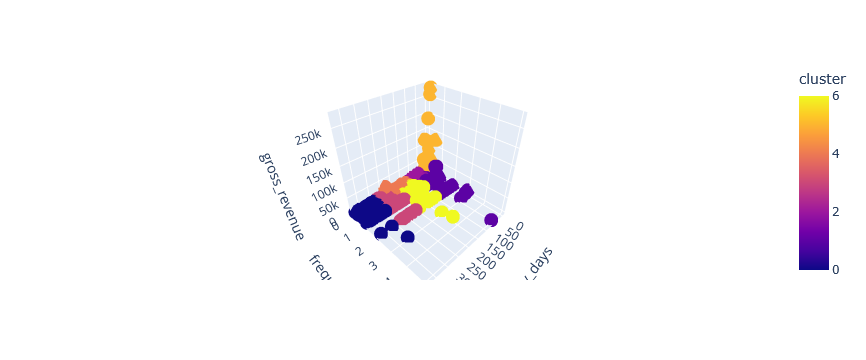

In [60]:
fig = px.scatter_3d(df6, x='recency_days', y='frequency', z='gross_revenue', color='cluster')
fig.show()

### 9.2 **Cluster Profile**

In [61]:
# número de customers
df_cluster = df6[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id'] / df_cluster['customer_id'].sum()) * 100

# gross revenue média
df_avg_gross_revenue = df6[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# recency days média
df_avg_recency_days = df6[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# frequency média
df_avg_frequency = df6[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on='cluster')

# qtde products returns média
df_avg_qtde_prod_returns = df6[['qtde_prod_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_qtde_prod_returns, how='inner', on='cluster')

# qtde invoices média
df_avg_qtde_invoices = df6[['qtde_invoices', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_qtde_invoices, how='inner', on='cluster')

# qtde products média
df_avg_qtde_prod = df6[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_qtde_prod, how='inner', on='cluster')

# qtde returns média
df_avg_qtde_returns = df6[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_qtde_returns, how='inner', on='cluster')

# gross revenue total do cluster
aux = df6[['gross_revenue', 'cluster']].groupby('cluster').sum().reset_index()
df_cluster = pd.merge(df_cluster, aux.rename(columns={'gross_revenue': 'gross_revenue_total'}), how='inner', on='cluster')

In [62]:
df_cluster = df_cluster.sort_values(by='gross_revenue', ascending=False)
df_cluster

cluster  customer_id  perc_customer  gross_revenue  recency_days  \
5        5         1768      31.050228    3634.610385     17.272059   
2        2          696      12.223393    1309.162126     78.133621   
1        1          967      16.982789     903.213847     44.998966   
4        4          327       5.742887     901.225046    181.868502   
0        0          618      10.853530     762.143366    336.459547   
6        6          617      10.835968     683.011135    154.163695   
3        3          701      12.311205     548.225792    249.231098   

   frequency  qtde_prod_returns  qtde_invoices  qtde_products  qtde_returns  \
5   0.047396          42.343891       7.502262    2175.403846      1.411199   
2   0.040525          12.231322       3.543103     841.915230      0.701149   
1   1.036096           1.483971       1.050672     354.048604      0.019648   
4   0.055342          12.706422       2.681957     527.461774      0.605505   
0   0.908999           1.483819       1.169903     251.331715      0.119741   
6   1.023312           0.322528       1.025932     238.387358      0.024311   
3   0.943176           3.858773       1.105563     208.191155      0.082739   

   gross_revenue_total  
5           6425991.16  
2            911176.84  
1            873407.79  
4            294700.59  
0            471004.60  
6            421417.87  
3            384306.28

In [ ]:
### Cluster 05:  (Candidato à Insider)
    - Número de customers: 1768 (31,05% dos customers total)
    - Receita média: $3634,6
    - Recência média: 17 dias
    - Frequência de compra média: 0,047/dia
    - Produtos retornados média: 42
    - Número de pedidos médio: 7,5
    - Quantidade de produtos média: 2175
    - Quantidade de retornos média: 1,4
    - Receita total do cluster: $6.425.991,16 
        
### Cluster 02: 
    - Número de customers: 696 (12,22% dos customers total)
    - Receita média: $1309,1
    - Recência média: 78 dias
    - Frequência de compra média: 0,040/dia
    - Produtos retornados média: 12
    - Número de pedidos médio: 3,5
    - Quantidade de produtos média: 841
    - Quantidade de retornos média: 0,7
    - Receita total do cluster: $911.176,84
        
### Cluster 01: 
    - Número de customers: 967 (16,98% do customers)
    - Receita média: $903,2
    - Recência média: 45 dias
    - Frequência de compra média: 1,03/dia
    - Produtos retornados média: 1,5
    - Número de pedidos médio: 1,05
    - Quantidade de produtos média: 354
    - Quantidade de retornos média: 0,02
    - Receita total do cluster: $873.407,79

### Cluster 04: 
    - Número de customers: 327 (5,74% dos customers total)
    - Receita média: $901,2
    - Recência média: 182 dias
    - Frequência de compra média: 0,05/dia
    - Produtos retornados média: 13
    - Número de pedidos médio: 2,6
    - Quantidade de produtos média: 527
    - Quantidade de retornos média: 0,60
    - Receita total do cluster: $294.700,59

### Cluster 00: 
    - Número de customers: 618 (10,85% dos customers total)
    - Receita média: $762,1
    - Recência média: 336 dias
    - Frequência de compra média: 0,90/dia
    - Produtos retornados média: 1,48
    - Número de pedidos médio: 1,17
    - Quantidade de produtos média: 251
    - Quantidade de retornos média: 0,12
    - Receita total do cluster: $471.004,60

### Cluster 06: 
    - Número de customers: 617 (10,83% dos customers total)
    - Receita média: $683,0
    - Recência média: 154 dias
    - Frequência de compra média: 1,02/dia
    - Produtos retornados média: 0,32
    - Número de pedidos médio: 1,02
    - Quantidade de produtos média: 238
    - Quantidade de retornos média: 0,02
    - Receita total do cluster: $421.417,87

### Cluster 03: 
    - Número de customers: 701 (12,31% dos customers total)
    - Receita média: $548,2
    - Recência média: 249 dias
    - Frequência de compra média: 0,94/dia
    - Produtos retornados média: 3,85
    - Número de pedidos médio: 1,10
    - Quantidade de produtos média: 208
    - Quantidade de retornos média: 0,08
    - Receita total do cluster: $384.306,28